__single-cell Analysis__ 

*by Maren Büttner*

Institute of Computational Biology, HelmholtzZentrum München


In [2]:
library(ggplot2)
library(gplots)
library(colorRamps)
library(RColorBrewer)
library(scatterplot3d)
library(TTR)
library(ComplexHeatmap)
library(circlize)
library(Rtsne)
library(destiny)
library(reshape)
library(pheatmap)

options(jupyter.plot_mimetypes = 'image/png')


# Introduction

In this notebook, we re-analyse a data set from *Paul et al: Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors* (**Cell 2015**)<cite>[1]</cite>. The authors identified 19 clusters in scRNAseq data of murine bone marrow with different transcriptional profiles and assigned them to different cell fates (Fig. 1). 

This snapshot of a differentiating population is ideal to apply the framework of diffusion maps and pseudotemporal ordering. Briefly, diffusion maps order cell transcription profiles by their similarity and approximate the non-linear manifold spanned by the data. In this way, we create cell trajectories including branching events. In a second step, pseudotemporal ordering assigns a pseudotime to each cell starting from a pre-defined *root cell*. The pseudotime encodes the degree of differentiation starting from the root. In a sense, we draw a line into each trajectory and project all cells onto the line. 

For branching events, an *area* of uncertainty is defined, where cells cannot be assigned to either of the branches. 

However, we assume there are several rather distinct cluster of cells without transition state, i.e. the population of precursors is already subdivided into cells with a defined fate. Even though they appear to be undifferentiated precursors in FACS or microscopic data, their transcriptome has already defined a certain lineage. 


<img src="Paul_Fig1.png" />

**Fig 1 (*Paul et al*):** Unbiased Reconstruction of Myeloid Progenitors

(A) Schematic diagram of indexed single-cell sorting. Bone marrow suspension of heterogeneous cells (first panel) is single-cell sorted (without gating), while surface marker intensities are recorded (second panel) and linked to each sorted single cell by their well index (third panel). After MARS-seq (Jaitin et al., 2014), library preparation and sequencing, surface marker intensities are associated with single-cell transcriptome identities and plotted on an in silico FACS map.

(B) Expression of 3,461 differential genes across 2,730 myeloid progenitor (Lin− c-Kit+ Sca1−) single cells. Cells are portioned into 19 distinct clusters (C1–C19) of gene expression profiles.

(C) Expression of key genes.

(D) Schematic showing index sorting intensities of 100 individual cells. Conventional CMP, GMP, and MEP gates are indicated by dashed boxes in the in silico FACS. Lower-right pie chart inlays show frequency of sorted cells falling into the CMP (yellow), GMP (green), or MEP (red) gates.

(E) FACS-measured FcgR and CD34 protein expression levels for single cells in each cluster (C1–C19) as in (D).


# Data import

We used the DPT algorithm to create a pseudotemporal order <cite>[2]</cite>. Apparently, the order is dependent on the root cell where we start ordering. In the case of bone marrow data, *Paul et al* found seven clusters being consecutively arranged on the erythroid lineage, starting from cluster C7 (the progenitor state) and going to C6-C1. In diffusion map plots of the data set, we also find these cells arranged in a single branch, but we observe a branching event in late stages.

Let us start by loading the data set.

In [4]:
load('../ICB/Teaching//161114_SC_workshop/Paul_Cell_MARSseq_GSE72857.RData')

In [5]:
ls()

[1] "batch.names"    "cluster.id"     "data"           "data.debatched"
[5] "info.genes"

Examine the loaded variables:

* data: post-processed UMI filtered reads for 8716 Genes and 2730 cells
* data.debatched: same size as *data*, but was regularized for the inter-batch differences
* batch.names: a vector with batch ID for each cell
* info.genes: a factor with all *informative genes* 
* cluster.id: a vector with cluster ID (identified in *Paul et al*) for each cell

In [6]:
dim(data.debatched)

[1] 8716 2730

Let us check the cluster sizes defined by *Paul et al*.

In [7]:
table(cluster.id)

cluster.id
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 43 329 246 124 180 173 167  68  63 153  30  69 300 373 186 164  22   9  31 

Create another data set using only *informative genes*. 

In [8]:
rownames(data.debatched)[1:10]
info.genes[1:10]

[1] "0610007L01Rik"                    "0610007P08Rik;Rad26l"            
 [3] "0610007P22Rik"                    "0610009B22Rik"                   
 [5] "0610009D07Rik"                    "0610009O20Rik"                   
 [7] "0610010F05Rik;mKIAA1841;Kiaa1841" "0610010K14Rik;Rnasek"            
 [9] "0610012G03Rik"                    "0610037P05Rik"

[1] Abcg4         8430419L09Rik Gtf2f1        Mcm4          Spna1        
 [6] Paqr9         Popdc2        Tapt1         Josd2         Tmem56       
3461 Levels: 0610007L01Rik 0610009O20Rik 0610010K14Rik ... Zzef1

We realize that the gene names are slightly different in the rownames of the data. Wherever we have multiple names, we split them and keep only the first name. 

In [9]:
gene.names <-sapply(strsplit(rownames(data.debatched), ";"), "[", 1)
is.informative <- gene.names %in% info.genes[order(info.genes)]
data.info.genes <- data.debatched[is.informative,]
rownames(data.info.genes) <- gene.names[is.informative]

In [10]:
dim(data.info.genes)

[1] 3451 2730

Instead of 3461 genes, we only have 3451. Let us check the names of the 10 genes we lost:

In [11]:
info.genes[!info.genes %in% gene.names[is.informative]]

[1] 42068 42065 42251 42255 42258 42248 42249 42071 42256 42254
3461 Levels: 0610007L01Rik 0610009O20Rik 0610010K14Rik ... Zzef1

Strangely, we have 5 digit numbers. Originally, we extracted the list of informative genes from the Excel file *Supplementary Table S3* in *Paul et al*. It appears that gene names that resemble a date (like *'Oct4'*) were automatically converted into dates, which are stored in a different format internally and it is fairly difficult to reconstruct the original name. 

Also, we check the number of filtered genes if we simply match rownames of the data set with the vector of informative genes:

In [12]:
sum(rownames(data.debatched) %in% info.genes)

[1] 3004

# Some quality metrics

We assume that the processing of the data set plus debatching resulted in a mainly unbiased data set. In this section, we would like to get a general idea how the data set 'looks like': 

* How many UMI filtered reads were sequenced per cell?
* How many genes were detected?
* What is the mean expression per gene?
* What is the variance in expression per gene?
* What is the squared coefficient of variation per gene?
* What is the drop-out rate per gene?
* Is there a difference in the number of total reads per batch?


The filtering procedure of *Paul et al* is applying a downsampling approach: "*For our analysis of myeloid progenitor populations reported here, this was done by creating a down-sampled UMI table from the index sort dataset (Figure 1), where from each cell we sample C UMIs without replacement (as in (Jaitin et al., 2014)), where C is the 0.2 quantile of the total UMIs per cell. We then filtered genes with total UMI count lower than 5 and variance-to-mean ratio lower than 1.2 [..]*"

In [13]:
quantile.cell <- quantile(colSums(data), 0.2)

In [14]:
quantile.cell

20% 
1216

If you have time, you may try to refilter the data set according to *Paul et al*. However, we will stick to the reported *informative* genes.

## Examine the full data set (before debatching)

**TASKS:**
* Plot number of detected genes vs. number of UMI filtered reads per cell
* Plot mean expression vs. squared coefficient of variation (x and y axis in log scale)
* Plot variance vs. mean expression
* Plot mean expression vs. drop out (x axis in log scale)
* Plot squared coefficient of variation vs. drop out (x axis in log scale)
* Plot the number of detected genes per cell sorted by batch (use the boxplot() function)
* Plot the number of UMI filtered reads per cell sorted by batch (use the boxplot() function)

**BONUS:**
* create a log-linear fit of the mean-cv2-relation and include it in your plot
* create a logistic regression of the log(mean)-dropout-relation and include it in your plot

**SOLUTIONS:**

In [15]:
total.counts <- colSums(data)
total.genes <- apply(data, 2, function(x) {sum(x>0)})
mean.counts  <- rowMeans(data)
var.counts <- apply(data, 1, var)
cv2.counts <- apply(data, 1, function(x) {var(x)/mean(x)^2})
drop.out <- apply(data, 1, function(x) {sum(x==0)/length(x)})

Define some colors (with transparent points):

In [16]:
addalpha <- function(colors, alpha=1.0) {
     r <- col2rgb(colors, alpha=T)
     # Apply alpha
     r[4,] <- alpha*255
     r <- r/255.0
     return(rgb(r[1,], r[2,], r[3,], r[4,]))
}

In [17]:
color.pal <- colorRampPalette(c('blue','red'))(20) 
color.pal2 <- addalpha(colorRampPalette(rev(brewer.pal(8, 'RdYlBu')))(20), alpha=0.3)
transparent.grey <- rgb(0.2,0.2,0.2, 0.3)


Create plots: 

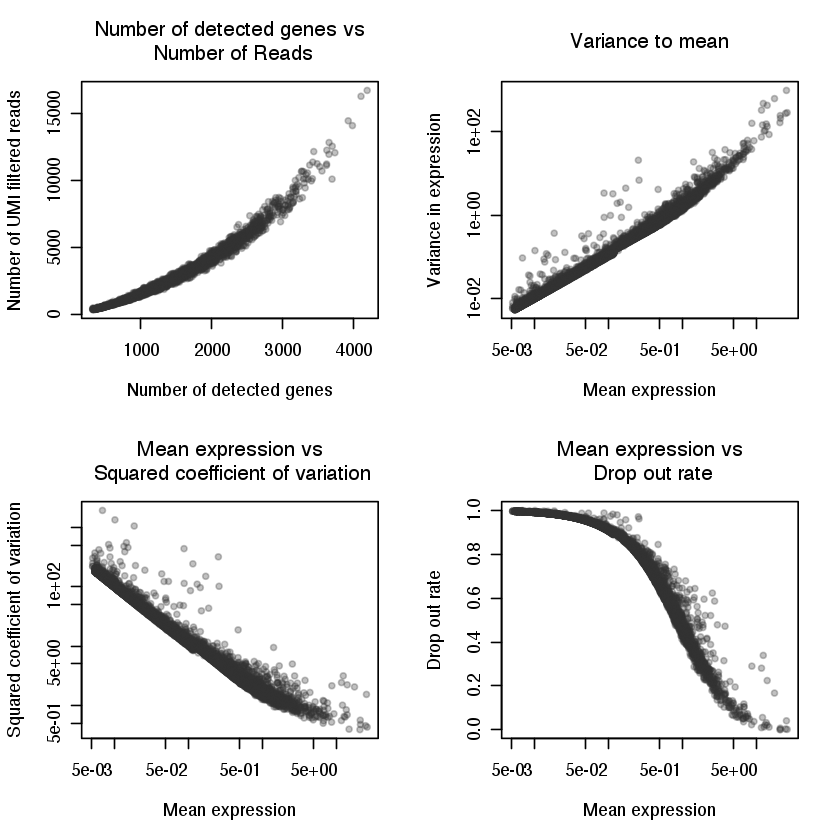

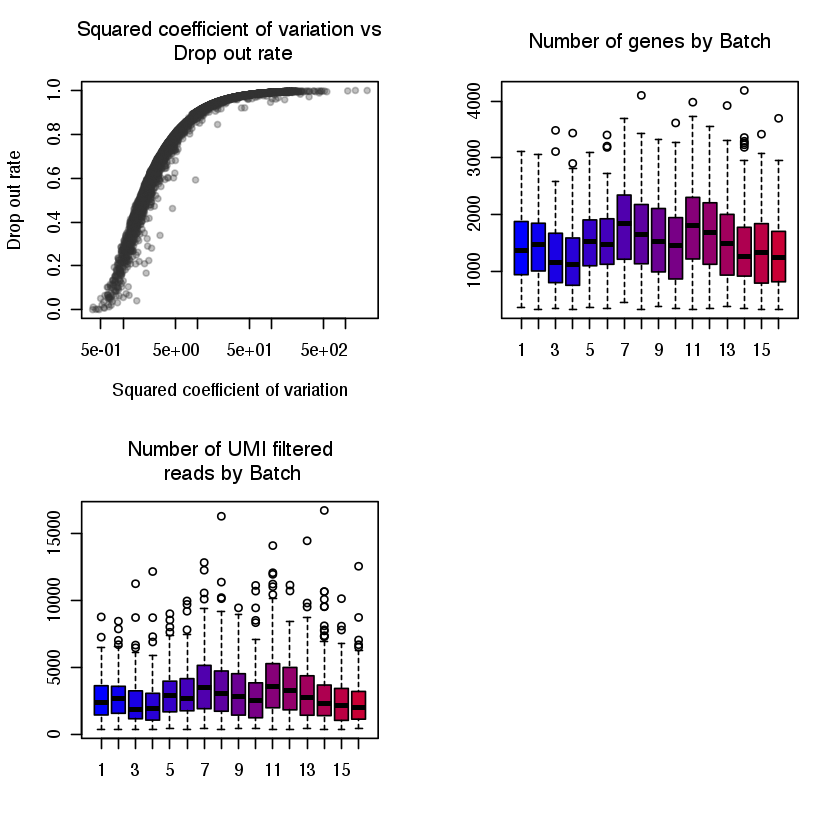

In [18]:
par(mfrow=c(2,2)) #smaller plots, 2 per row, 2 per column
plot(total.genes, total.counts, 
     pch=20,col=transparent.grey,
     xlab= 'Number of detected genes',
     ylab= 'Number of UMI filtered reads',
     main='Number of detected genes vs\n Number of Reads')
plot(mean.counts, var.counts, log='xy', 
     pch=20,col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Variance in expression',
     main='Variance to mean')
plot(mean.counts, cv2.counts, log='xy', 
     pch=20, col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Squared coefficient of variation',
     main='Mean expression vs\n Squared coefficient of variation')
plot(mean.counts, drop.out, log='x', 
     pch=20, col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Drop out rate',
     main='Mean expression vs\n Drop out rate')

plot(cv2.counts, drop.out, log='x', 
     pch=20,col=transparent.grey,
     xlab= 'Squared coefficient of variation',
     ylab= 'Drop out rate',
     main='Squared coefficient of variation vs\n Drop out rate')



boxplot(total.genes ~ batch.names,  col=color.pal, main='Number of genes by Batch')
boxplot(total.counts ~ batch.names,  col=color.pal, main='Number of UMI filtered\n reads by Batch')

## Examine the debatched data set

Let us compute the same metrics for the debatched data. The debatching procedure is described in very detail in the supplement of <cite>[1] </cite>. However, the scripts to create a debatched data set are provided on the webpage of Amos Tanay's lab: http://compgenomics.weizmann.ac.il/tanay/

**TASKS:**
* Plot number of detected genes vs. number of UMI filtered reads per cell
* Plot mean expression vs. squared coefficient of variation (x and y axis in log scale) *AND* highlight the informative genes
* Plot variance vs. mean expression
* Plot mean expression vs. drop out (x axis in log scale)
* Plot squared coefficient of variation vs. drop out (x axis in log scale)
* Plot the number of detected genes per cell sorted by batch (use the boxplot() function)
* Plot the number of UMI filtered reads per cell sorted by batch (use the boxplot() function)

**SOLUTIONS:**

In [19]:
total.count.debatch <- colSums(data.debatched)
total.genes.debatch <- apply(data.debatched, 2, function(x) {sum(x>0)})
mean.counts.debatch  <- rowMeans(data.debatched)
cv2.counts.debatch <- apply(data.debatched, 1, function(x) {var(x)/mean(x)^2})
var.counts.debatch <- apply(data.debatched, 1, var)
drop.out.debatch <- apply(data.debatched, 1, function(x) {sum(x==0)/length(x)})

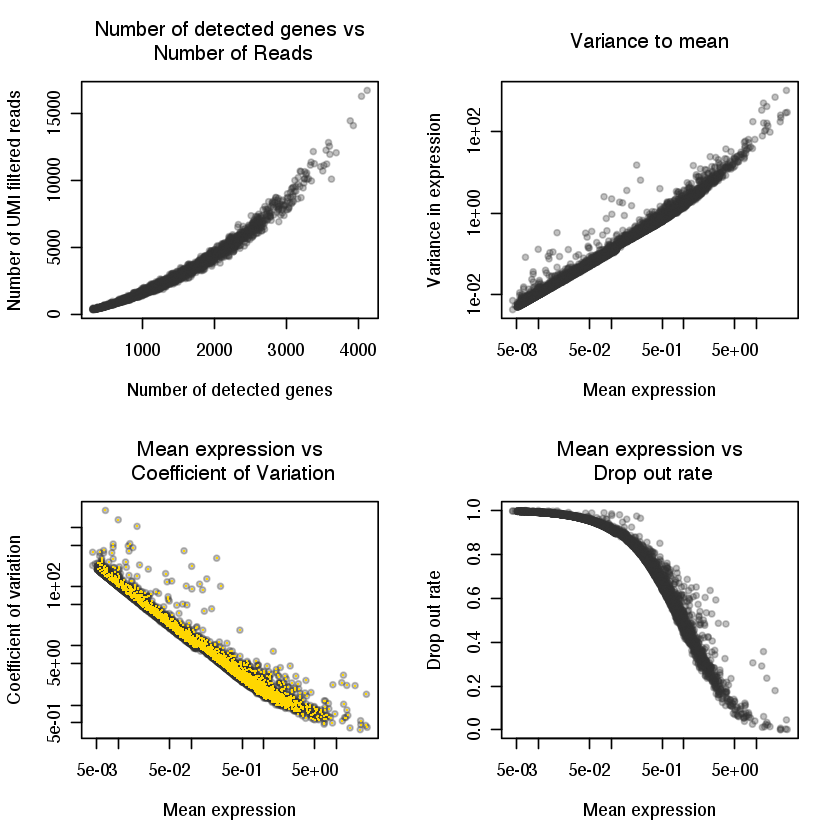

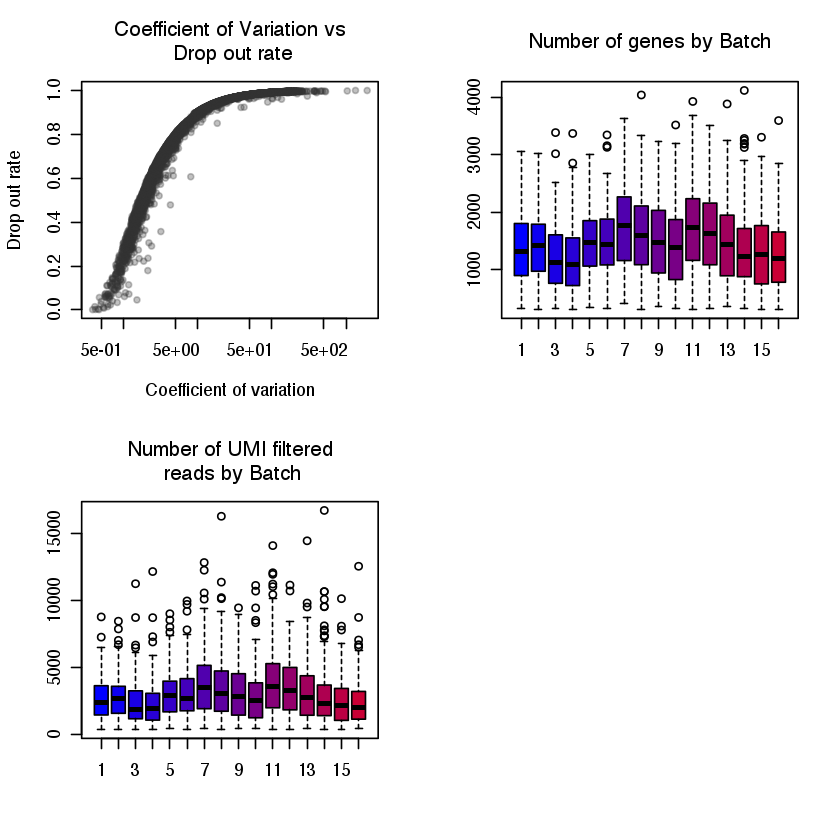

In [20]:
par(mfrow=c(2,2)) #smaller plots, 2 per row, 2 per column
plot(total.genes.debatch, total.count.debatch, 
     pch=20,col=transparent.grey,
     xlab= 'Number of detected genes',
     ylab= 'Number of UMI filtered reads',
     main='Number of detected genes vs\n Number of Reads')
plot(mean.counts.debatch, var.counts.debatch, log='xy', 
     pch=20,col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Variance in expression',
     main='Variance to mean')
plot(mean.counts.debatch, cv2.counts.debatch, log='xy', 
     pch=20, col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Coefficient of variation',
     main='Mean expression vs\n Coefficient of Variation')
points(mean.counts.debatch[is.informative], cv2.counts.debatch[is.informative], col='gold', pch='.')
plot(mean.counts.debatch, drop.out.debatch, log='x', 
     pch=20, col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Drop out rate',
     main='Mean expression vs\n Drop out rate')

plot(cv2.counts.debatch, drop.out.debatch, log='x', 
     pch=20,col=transparent.grey,
     xlab= 'Coefficient of variation',
     ylab= 'Drop out rate',
     main='Coefficient of Variation vs\n Drop out rate')


boxplot(total.genes.debatch ~ batch.names,  col=color.pal, main='Number of genes by Batch')
boxplot(total.count.debatch ~ batch.names,  col=color.pal, main='Number of UMI filtered\n reads by Batch')



## Comparison of processed data and debatched data

When we examine the various plots, we have a hard time to identify any differences of the data and the debatched data. 

** TASKS:**

Plot and correlate 
* mean expression
* coefficient of variation
* drop out rate
of the processed and debatched data

**SOLUTIONS:**

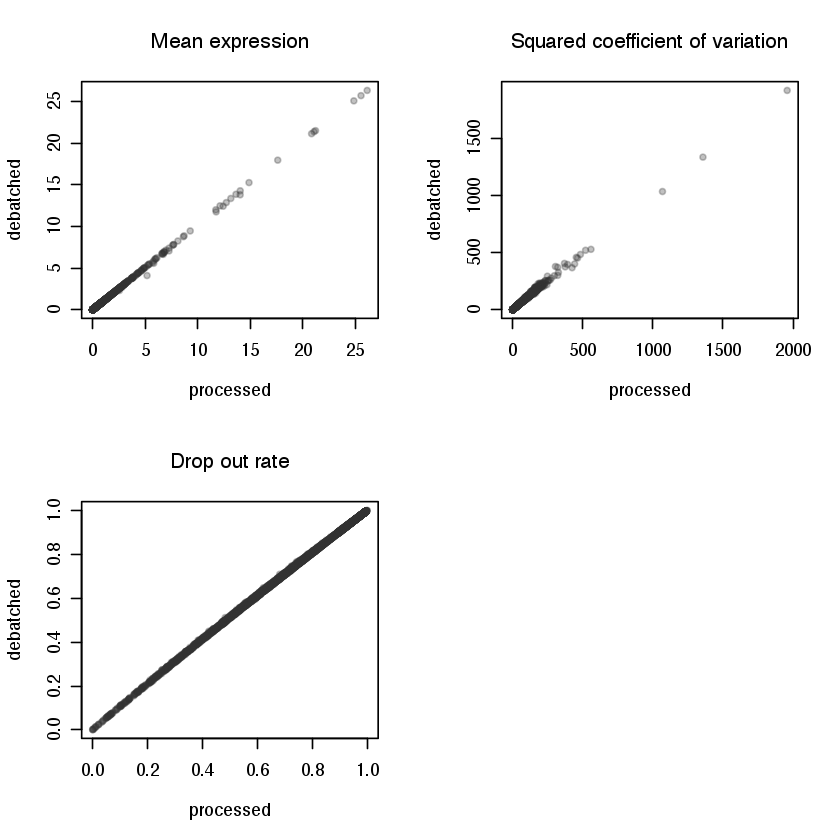

In [21]:
par(mfrow=c(2,2))
plot(mean.counts , mean.counts.debatch, pch=20,
     col = transparent.grey,
     xlab = 'processed', 
     ylab = 'debatched',
     main = 'Mean expression')
plot(cv2.counts , cv2.counts.debatch, pch=20,
     col= transparent.grey,
     xlab = 'processed', 
     ylab = 'debatched',
     main = 'Squared coefficient of variation')
plot(drop.out, drop.out.debatch, pch=20,
     col = transparent.grey,
     xlab = 'processed', 
     ylab = 'debatched',
     main = 'Drop out rate')

## Examine the data set of informative genes

**TASKS:**
* Plot number of detected genes vs. number of UMI filtered reads per cell
* Plot mean expression vs. squared coefficient of variation (x and y axis in log scale)
* Plot variance vs. mean expression
* Plot mean expression vs. drop out (x axis in log scale)
* Plot squared coefficient of variation vs. drop out (x axis in log scale)
* Plot the number of detected genes per cell sorted by batch (use the boxplot() function)
* Plot the number of UMI filtered reads per cell sorted by batch (use the boxplot() function)

**SOLUTIONS:**

In [22]:
total.count.info <- colSums(data.info.genes)
total.genes.info <- apply(data.info.genes, 2, function(x) {sum(x>0)})
mean.counts.info  <- rowMeans(data.info.genes)
cv2.counts.info <- apply(data.info.genes, 1, function(x) {var(x)/mean(x)^2})
var.counts.info <- apply(data.info.genes, 1, var)
drop.out.info <- apply(data.info.genes, 1, function(x) {sum(x==0)/length(x)})

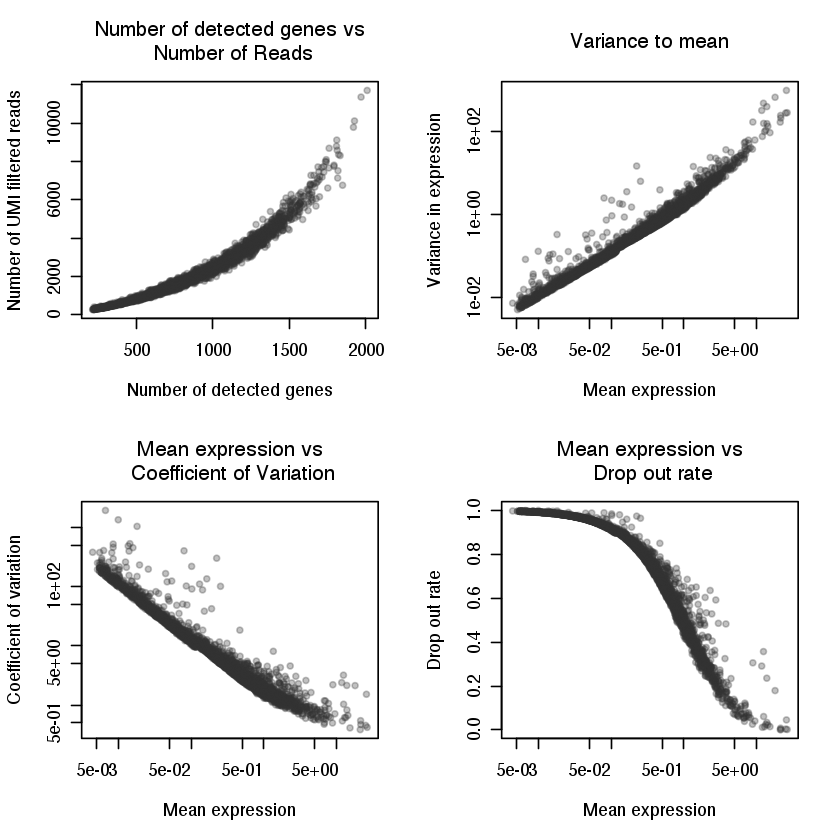

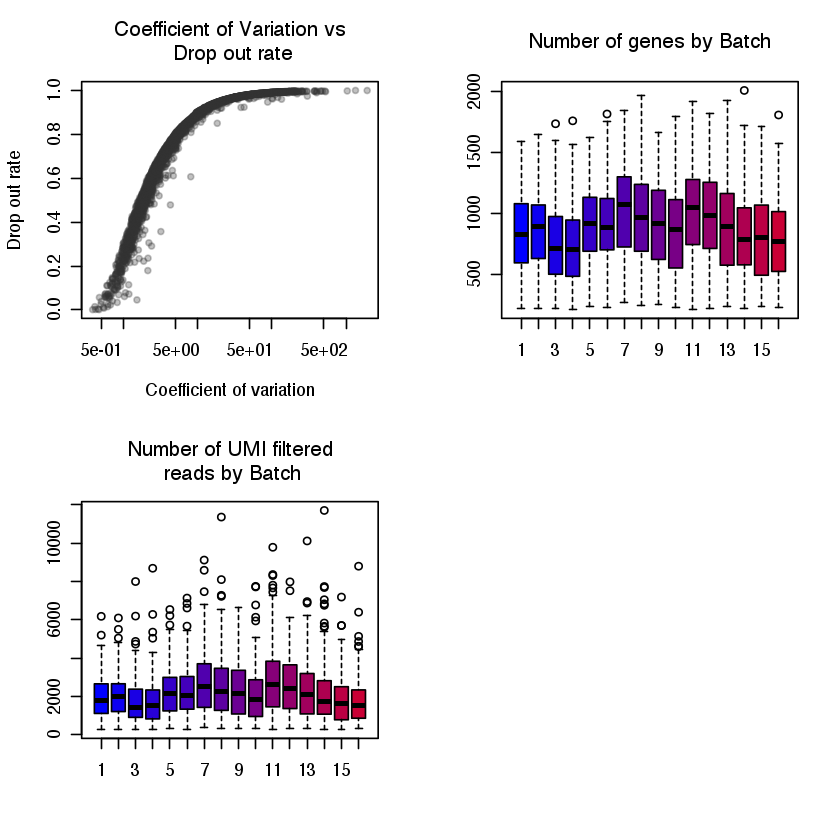

In [23]:
par(mfrow=c(2,2)) #smaller plots, 2 per row, 2 per column
plot(total.genes.info, total.count.info, 
     pch=20,col=transparent.grey,
     xlab= 'Number of detected genes',
     ylab= 'Number of UMI filtered reads',
     main='Number of detected genes vs\n Number of Reads')
plot(mean.counts.info, var.counts.info, log='xy', 
     pch=20,col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Variance in expression',
     main='Variance to mean')
plot(mean.counts.info, cv2.counts.info, log='xy', 
     pch=20, col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Coefficient of variation',
     main='Mean expression vs\n Coefficient of Variation')
plot(mean.counts.info, drop.out.info, log='x', 
     pch=20, col=transparent.grey,
     xlab= 'Mean expression',
     ylab= 'Drop out rate',
     main='Mean expression vs\n Drop out rate')

plot(cv2.counts.info, drop.out.info, log='x', 
     pch=20,col=transparent.grey,
     xlab= 'Coefficient of variation',
     ylab= 'Drop out rate',
     main='Coefficient of Variation vs\n Drop out rate')


boxplot(total.genes.info ~ batch.names,  col=color.pal, main='Number of genes by Batch')
boxplot(total.count.info ~ batch.names,  col=color.pal, main='Number of UMI filtered\n reads by Batch')


# Dimensionality reduction

Dimensionality reduction serves as a first step towards the analysis of a high-dimensional data set. We continue the analysis with the **set of informative genes** to have the possibility of direct comparison with the results of *Paul et al*. 

This section covers the following methods:

* Principal component analysis (PCA)
* t-distributed stochastic neighbourhood embedding (t-SNE)
* Diffusion maps 

## Principal component analysis (PCA)

In brief, principal component analysis is a linear transformation with respect to the variance of the data. It is the simplest approach for dimensionality reduction and assumes that the data is (multivariate) normal distributed. Every principal component explains a certain amount of the variance in the data set and they are automatically ordered by the explained variance per component. However, the performance and explanatory value of PCA is diminishing if the data set is high-dimensional and/or skewed. Usually, we observe that scRNAseq data is sparse, high dimensional and follows rather the negative binomial distribution. Still, it is a good start to use a simple, easy-to-interpret method for a first analysis of an unknown data set. 

**TASKS:**

* Compute a principal component analysis of the data (use the *prcomp()* function)
* Compute the explained variance per principal component
* Visualise the PCA of the data
* Create several PCA plots for the genes *Hbb-b1*, *Sfpi1* and *Apoe*

**SOLUTIONS:**

Compute a PCA.

In [24]:
pca.data <- prcomp(t(data.info.genes), center = TRUE, scale=TRUE)

Print a detailed overview of the data.

In [26]:
str(pca.data)

List of 5
 $ sdev    : num [1:2730] 22.71 11.43 5.83 5.08 4.56 ...
 $ rotation: num [1:3451, 1:2730] -0.01362 -0.01843 -0.02328 -0.00574 0.00194 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3451] "0610007L01Rik" "0610009O20Rik" "0610010K14Rik" "0910001L09Rik" ...
  .. ..$ : chr [1:2730] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:3451] 0.4908 0.2835 1.5136 0.622 0.0678 ...
  ..- attr(*, "names")= chr [1:3451] "0610007L01Rik" "0610009O20Rik" "0610010K14Rik" "0910001L09Rik" ...
 $ scale   : Named num [1:3451] 0.81 0.613 1.601 0.949 0.402 ...
  ..- attr(*, "names")= chr [1:3451] "0610007L01Rik" "0610009O20Rik" "0610010K14Rik" "0910001L09Rik" ...
 $ x       : num [1:2730, 1:2730] 23.1 4.5 -43.3 -19.5 -52 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2730] "W31105" "W31106" "W31107" "W31108" ...
  .. ..$ : chr [1:2730] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


Compute the explained variance per gene and define a random order of the cells for visualisation.

In [27]:
normal <- sum(pca.data$sdev^2)
var <- round((pca.data$sdev)^2 / normal *100,1)
ord <- sample(dim(pca.data$x)[1])

Visualise the PCA.

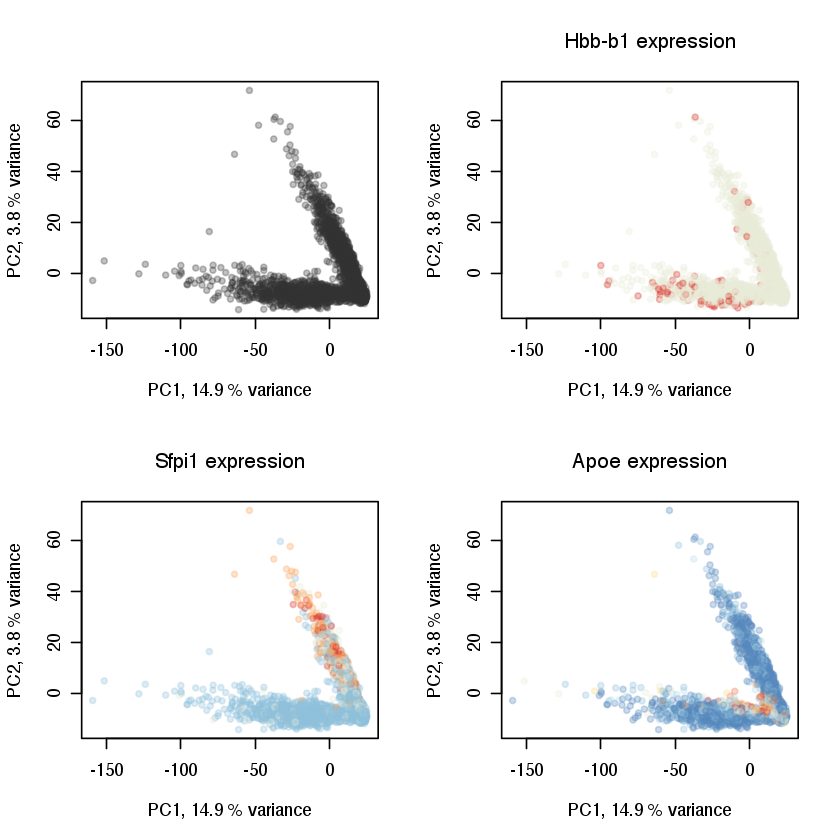

In [28]:
par(mfrow=c(2,2))
plot(pca.data$x[ord,1], pca.data$x[ord,2], 
     col=rgb(0.2,0.2,0.2,0.3), 
     xlab = paste0("PC1, ", var[1], " % variance"),
     ylab = paste0("PC2, ", var[2], " % variance"),
     pch= 20)

plot(pca.data$x[ord,1], pca.data$x[ord,2], 
     col=color.pal2[(1+data.info.genes['Hbb-b1',ord])/quantile(data.info.genes['Hbb-b1',], 0.98)*20], 
     xlab = paste0("PC1, ", var[1], " % variance"),
     ylab = paste0("PC2, ", var[2], " % variance"),
     main='Hbb-b1 expression',
     pch= 20)

plot(pca.data$x[ord,1], pca.data$x[ord,2], 
     col=color.pal2[(1+data.info.genes['Sfpi1',ord])/quantile(data.info.genes['Sfpi1',], 0.98)*20], 
     xlab = paste0("PC1, ", var[1], " % variance"),
     ylab = paste0("PC2, ", var[2], " % variance"),
     main='Sfpi1 expression',
     pch= 20)

plot(pca.data$x[ord,1], pca.data$x[ord,2], 
     col=color.pal2[(1+data.info.genes['Apoe',ord])/quantile(data.info.genes['Apoe',], 0.98)*20], 
     xlab = paste0("PC1, ", var[1], " % variance"),
     ylab = paste0("PC2, ", var[2], " % variance"),
     main='Apoe expression',
     pch= 20)

## t-distributed stochastic neighbourhood embedding (t-SNE)

t-SNE is an algorithm for dimension reduction of high dimensional data and involves the minimization of the Kullback-Leibler divergence to create a low-dimensional representation of the high dimensional data set. The method has a fairly local focus, i.e. structure within clusters is well resolved and distances between clusters poorly resolve their relation. Please consider the original publication for further details <cite>[3]</cite>. In general, it is difficult to develop an intuition about this type of dimensionality reduction, but a graphic and interactive explanation to parameters as *perplexity* ("a smooth measure of the effective number of neighbors" <cite>[3]</cite>) can be found in http://distill.pub/2016/misread-tsne/ (Thanks to Jens for the comment).

**TASKS:**

* Compute a t-SNE of the data (use the *Rtsne()* function)
* Visualise the t-SNE of the data, create several plots for the genes *Hbb-b1*, *Sfpi1* and *Apoe*

**SOLUTIONS:**

In [29]:
tsne.done <- Rtsne(t(data.info.genes), perplexity = 40, max_iter = 2000)


In [30]:
tsne.wo.pca <- Rtsne(t(data.info.genes), perplexity = 40, max_iter = 4000, pca = FALSE)

In [31]:
str(tsne.done)

List of 7
 $ theta     : num 0.5
 $ perplexity: num 40
 $ N         : int 2730
 $ origD     : int 50
 $ Y         : num [1:2730, 1:2] -25.59 6.51 10.83 9.63 7.27 ...
 $ costs     : num [1:2730] 0.000389 0.000303 0.000538 0.000182 0.00025 ...
 $ itercosts : num [1:40] 75 65 64 63.8 63.7 ...


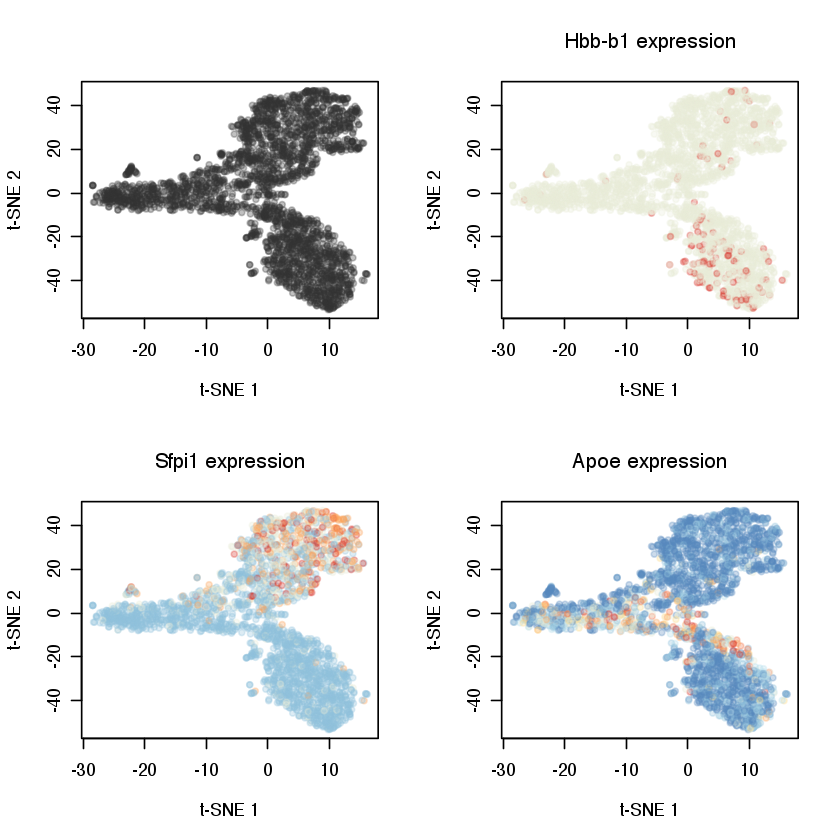

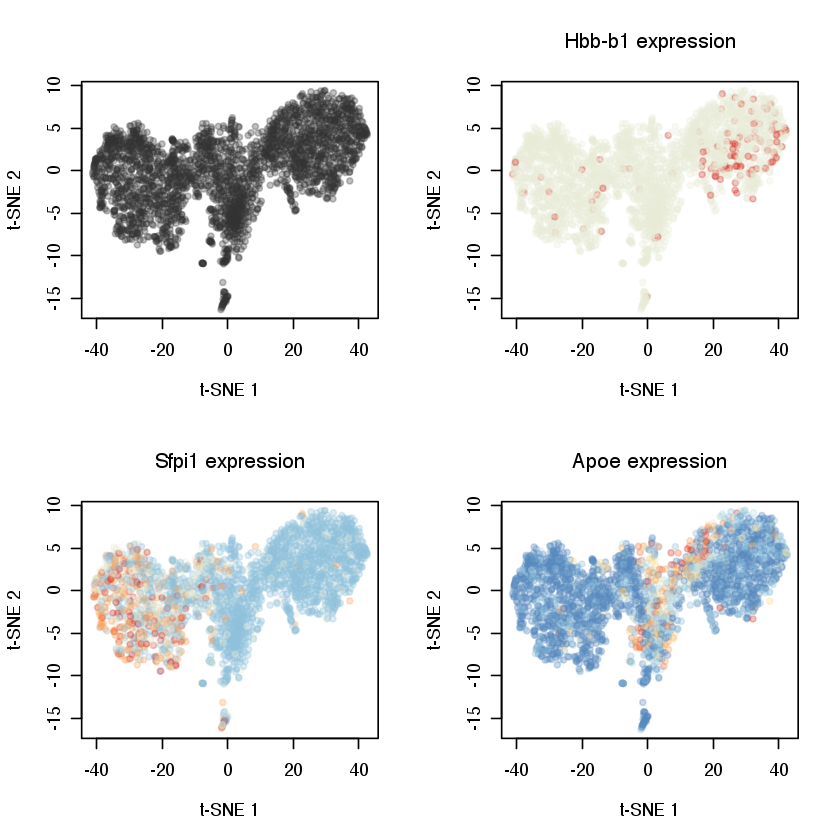

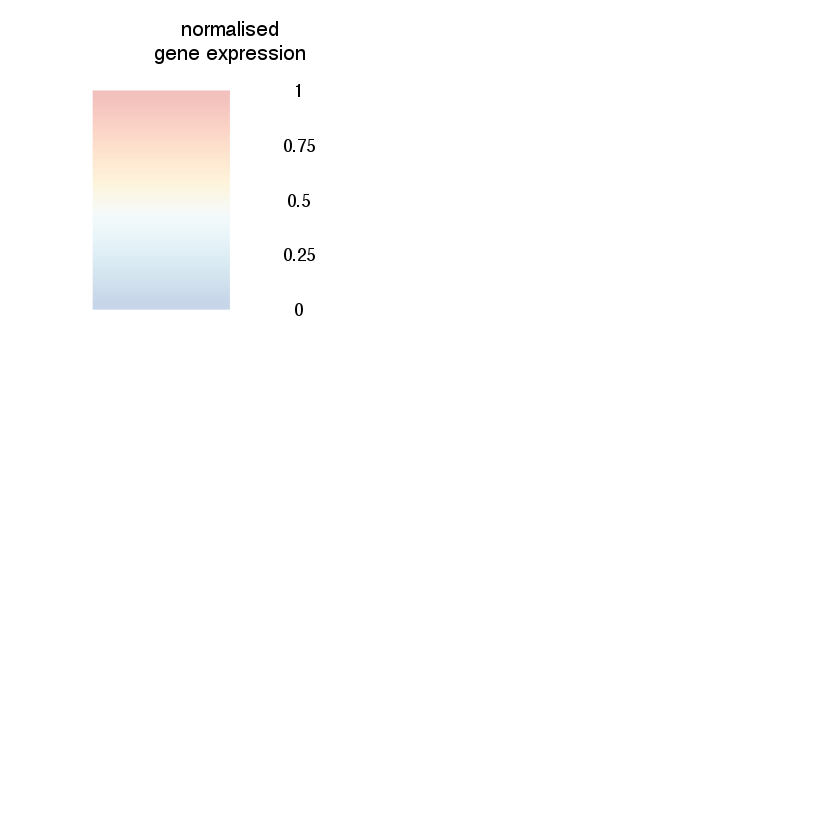

In [32]:
par(mfrow=c(2,2))
plot(tsne.done$Y, col=transparent.grey, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     pch=20)
plot(tsne.done$Y[ord,], 
     col=color.pal2[(1+data.info.genes['Hbb-b1',ord])/quantile(data.info.genes['Hbb-b1',], 0.98)*20], 
     pch=20, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     main='Hbb-b1 expression')
plot(tsne.done$Y[ord,], 
     col=color.pal2[(1+data.info.genes['Sfpi1',ord])/quantile(data.info.genes['Sfpi1',], 0.98)*20],  
     pch=20, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     main='Sfpi1 expression')
plot(tsne.done$Y[ord,], 
     col=color.pal2[(1+data.info.genes['Apoe',ord])/quantile(data.info.genes['Apoe',], 0.98)*20],  
     pch=20, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     main='Apoe expression')   

plot(tsne.wo.pca$Y, col=transparent.grey, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     pch=20)
plot(tsne.wo.pca$Y[ord,], 
     col=color.pal2[(1+data.info.genes['Hbb-b1',ord])/quantile(data.info.genes['Hbb-b1',], 0.98)*20], 
     pch=20, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     main='Hbb-b1 expression')
plot(tsne.wo.pca$Y[ord,], 
     col=color.pal2[(1+data.info.genes['Sfpi1',ord])/quantile(data.info.genes['Sfpi1',], 0.98)*20], 
     pch=20, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     main='Sfpi1 expression')
plot(tsne.wo.pca$Y[ord,], 
     col=color.pal2[(1+data.info.genes['Apoe',ord])/quantile(data.info.genes['Apoe',], 0.98)*20], 
     pch=20, 
     xlab= 't-SNE 1',
     ylab= 't-SNE 2',
     main='Apoe expression')  

#extra legend (use the grDevices package)
legend_image <- as.raster(matrix(color.pal2, ncol=1))
plot(c(0,2),c(0,1),type = 'n', axes = F,xlab = '', ylab = '', main = 'normalised\ngene expression')
text(x=1.5, y = seq(0,1,l=5), labels = seq(0,1,l=5))
rasterImage(legend_image, 1, 1, 0,0)


## Diffusion maps

Diffusion maps is a non-linear dimensionality reduction approach that employs a transition probability matrix constructed by the data. A detailed description of the method as well as its application to the single-cell setting can be found in <cite>[4]</cite>.


**TASKS:**

* Compute a diffusion map of the log-scaled data (use the *DiffusionMap()* function and use 20 nearest-neighbours)
* Visualise the diffusion map of the data, create several plots for the genes *Hbb-b1*, *Sfpi1* and *Apoe*

Hint: *?plot.DiffusionMap* reports the usage of the plotting function for DiffusionMaps.










**SOLUTIONS:**

Compute the diffusion map.

In [33]:
diff.plot <- DiffusionMap(log(t(data.info.genes)+1), k=20, sigma='local')


In [34]:
dim(diff.plot@eigenvectors)


[1] 2730   20

Visualise the results.

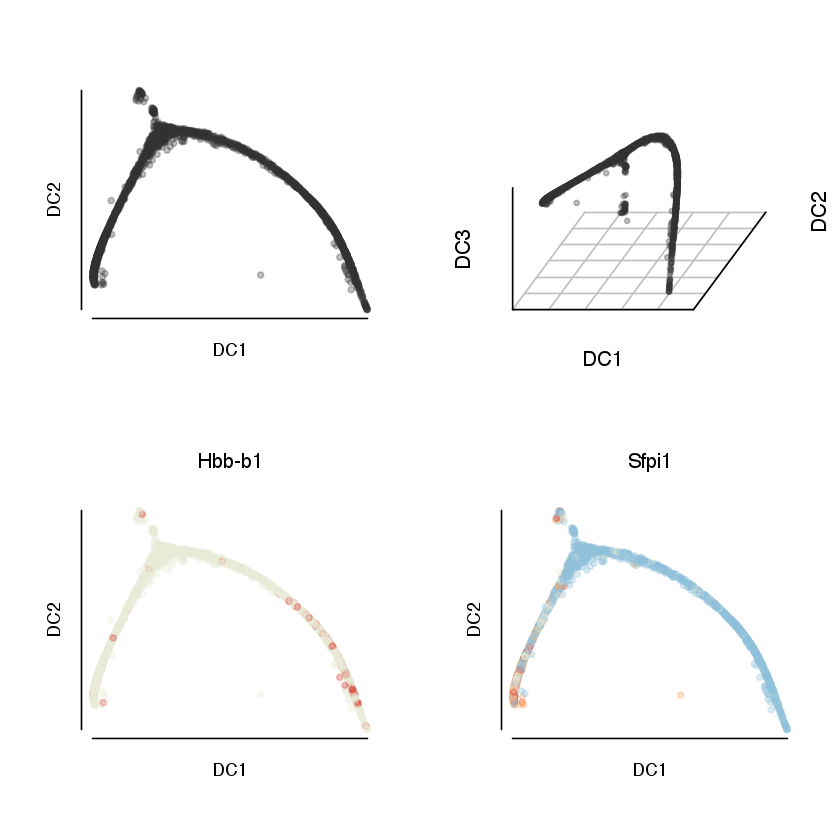

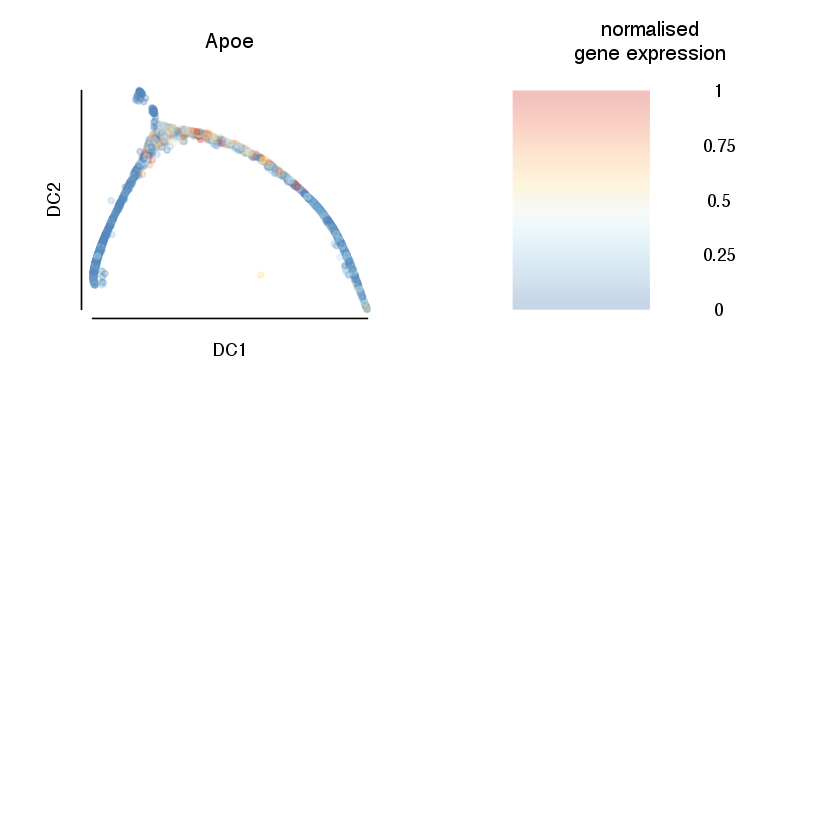

In [35]:
par(mfrow=c(2,2))
plot(diff.plot, 1:2, 
     col=transparent.grey, 
     pch=20, 
     axes=TRUE)

plot(diff.plot, 1:3, angle=60,
     col=transparent.grey, 
     pch=20, 
     axes=TRUE)

plot(diff.plot, 1:2,
     col = color.pal2[(1+data.info.genes['Hbb-b1',])/quantile(data.info.genes['Hbb-b1',], 0.98)*20],
     pch=20, 
     main='Hbb-b1',
     axes=TRUE)

plot(diff.plot, 1:2,
     col = color.pal2[(1+data.info.genes['Sfpi1',])/quantile(data.info.genes['Sfpi1',], 0.98)*20],
     pch=20, 
     main='Sfpi1',
     axes=TRUE)
plot(diff.plot, 1:2,
     col = color.pal2[(1+data.info.genes['Apoe',])/quantile(data.info.genes['Apoe',], 0.98)*20],
     pch=20, 
     main = 'Apoe',
     axes=TRUE)
#extra legend (use the grDevices package)
legend_image <- as.raster(matrix(color.pal2, ncol=1))
plot(c(0,2),c(0,1),type = 'n', axes = F,xlab = '', ylab = '', main = 'normalised\ngene expression')
text(x=1.5, y = seq(0,1,l=5), labels = seq(0,1,l=5))
rasterImage(legend_image, 1, 1, 0,0)


# Diffusion Pseudotime

Intuitively, we observe a path structure in all dimension reduction approaches. In the following, we employ diffusion pseudotime to order the cells along the paths for further analysis.

**TASKS:**

* Compute a diffusion pseudotime by using the diffusion map object (use the *DPT()* function, define tip cells as *tips = c(841, 1240, 878)*)
* Visualise the diffusion pseudotime of the data, create several plots to highlight DPT and the branches

**SOLUTIONS:**

Compute diffusion pseudotime.

In [36]:
dpt <- DPT(diff.plot, tips = c(841, 1240, 878))


Visualise the results.

In [37]:
color.branch <- addalpha(brewer.pal(8,'Paired'), 0.3)

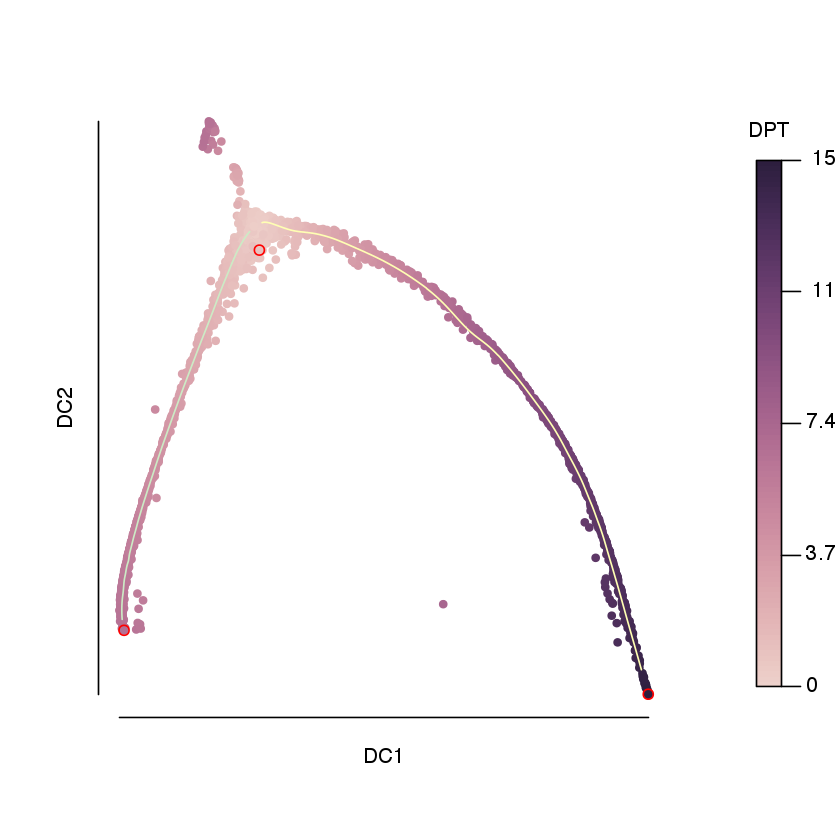

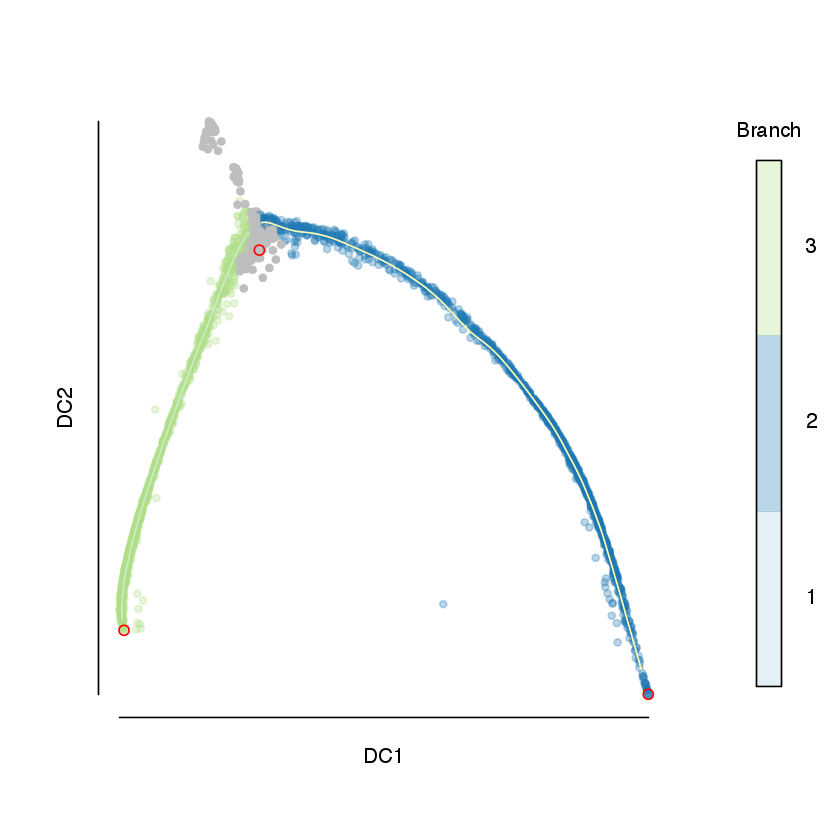

In [38]:
plot(dpt, 1:2, 
     col_by = 'dpt',  root = 1, paths_to = c(2,3),
     pch=20)
plot(dpt, 1:2, 
     col_by = 'Branch',  root = 1, paths_to = c(2,3), pal=color.branch,
     pch=20)


Let us check on the branching results. How many cells belong to which branch and which cells are unassigned?

In [39]:
head(dpt@branch)

table(dpt@branch[,1])
sum(is.na(dpt@branch[,1]))


Branch1 Branch2 Branch3 Branch4 Branch5 Branch6 Branch7 Branch8 Branch9
[1,] 2        5      31      NA      NA      NA      NA      NA      NA     
[2,] 3       NA      NA      NA      NA      NA      NA      NA      NA     
[3,] 2        4       8      11      NA      NA      NA      NA      NA     
[4,] 3       87      90      94      NA      NA      NA      NA      NA     
[5,] 2        4       7      NA      NA      NA      NA      NA      NA     
[6,] 3       NA      NA      NA      NA      NA      NA      NA      NA     
     Branch10
[1,] NA      
[2,] NA      
[3,] NA      
[4,] NA      
[5,] NA      
[6,] NA


   1    2    3 
   6 1160 1340 

[1] 224

## Iterating DPT

In this particular setting, we observe another branches now unassigned in the 3D plots. In order to assign these cells, we apply DPT again on the subset spanned by branch 1 (the trunk) and unassigned cells.

In [40]:
data.info.zoom <- data.info.genes[,dpt@branch[,1] %in% c(NA, 1)] 


In [41]:
dim(data.info.zoom)


[1] 3451  230

Let us restart the DPT algorithm with the same root as before. Hence, we have to find its new index in the residual data set. 

In [42]:
new.start <- which(colnames(data.info.zoom)==colnames(data.info.genes)[841])


In [43]:
diff.plot.zoom <- DiffusionMap(log(t(data.info.zoom)+1), k=20, sigma='local', n_local = 10)


In [44]:
dpt.zoom <- DPT(diff.plot.zoom, tips = new.start) 


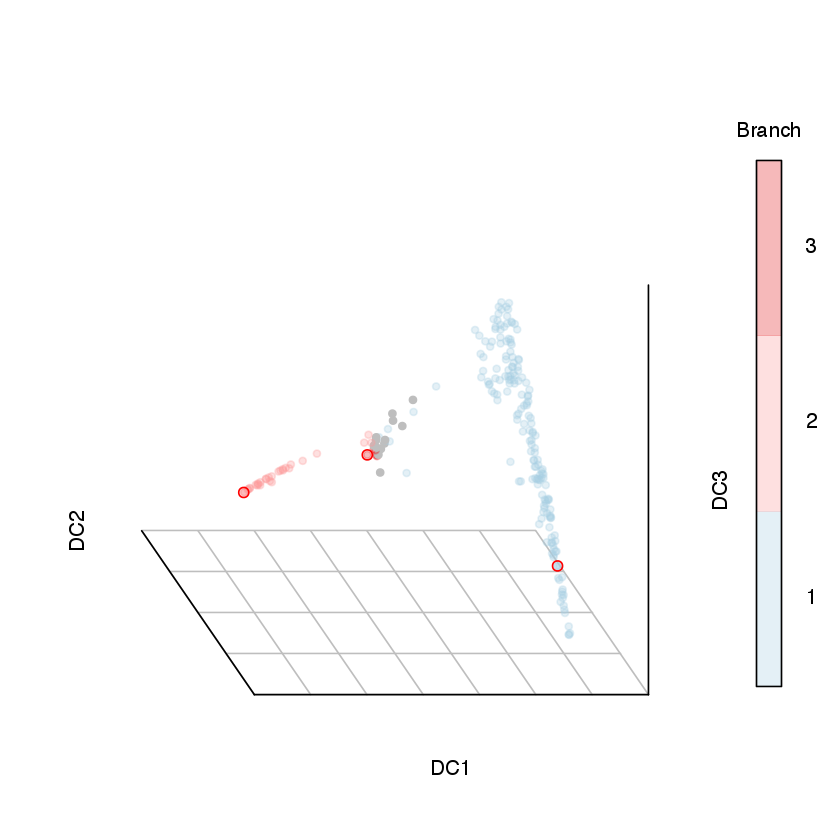

In [47]:
plot(dpt.zoom, col_by = 'branch',  pch = 20,dcs=c(1:3),angle=135, pal=color.branch[c(1,5,6)])



Again, we check how the cells distribute across the branches:

In [48]:
table(dpt.zoom@branch[,1])



  1   2   3 
181  31   5 

Summarize the branching results of both iterations:

In [49]:
branching <- numeric(dim(data.info.genes)[2])
branching[!is.na(dpt@branch[,1])] <- dpt@branch[!is.na(dpt@branch[,1]),1]
branching[dpt@branch[,1] %in% c(NA,1)][dpt.zoom@branch[,1]==1] <- 1


The results from iterating DPT need a new index for the subbranches.

In [50]:
dpt.zoom@branch[dpt.zoom@branch[,1] %in% 2:3,1] <- dpt.zoom@branch[dpt.zoom@branch[,1] %in% 2:3,1] + 3
dpt.zoom@branch[is.na(dpt.zoom@branch[,1]),1] <- 4
branching[branching==0] <- dpt.zoom@branch[dpt.zoom@branch[,1] !=1,1]


Let us plot the branches in a diffusion map.

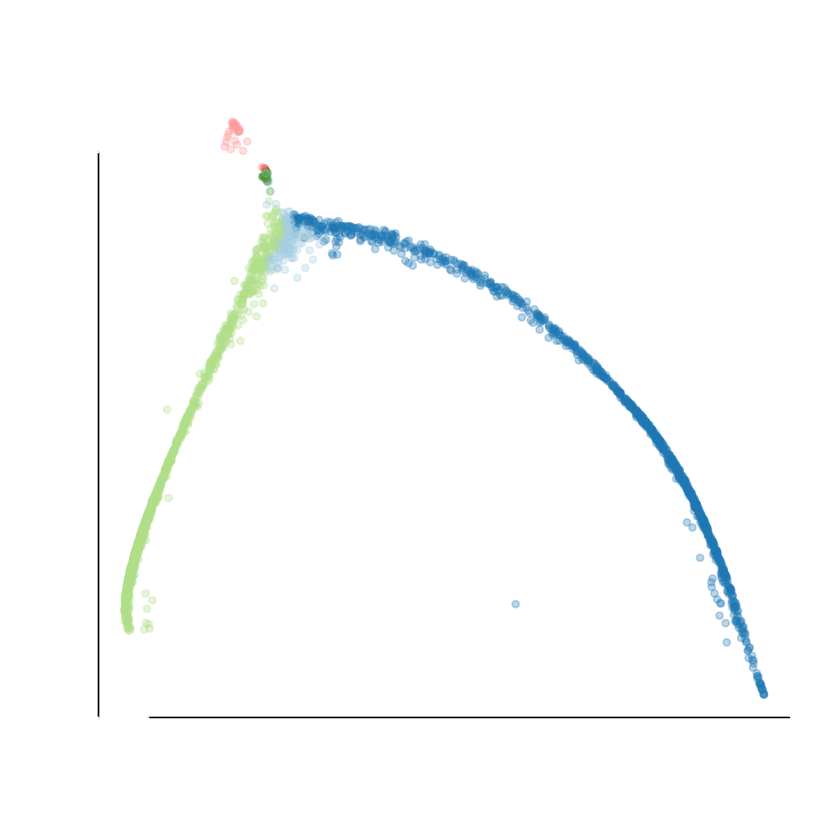

In [51]:
plot(eigenvectors(diff.plot)[,c(1,2)], col=color.branch[branching], pch=20, xlab='', ylab='', 
     axes=FALSE)
par(cex.lab=1.8)
axis(side=1, at=c(-0.05, 0.1), labels=NA,  col.ticks = 'white')
axis(side=2, at=c(-0.11, 0.11), labels=NA, col.ticks = 'white')


## Compare to original clustering

Now we are wondering how the diffusion pseudotime corresponds to the original clusters by *Paul et al*.

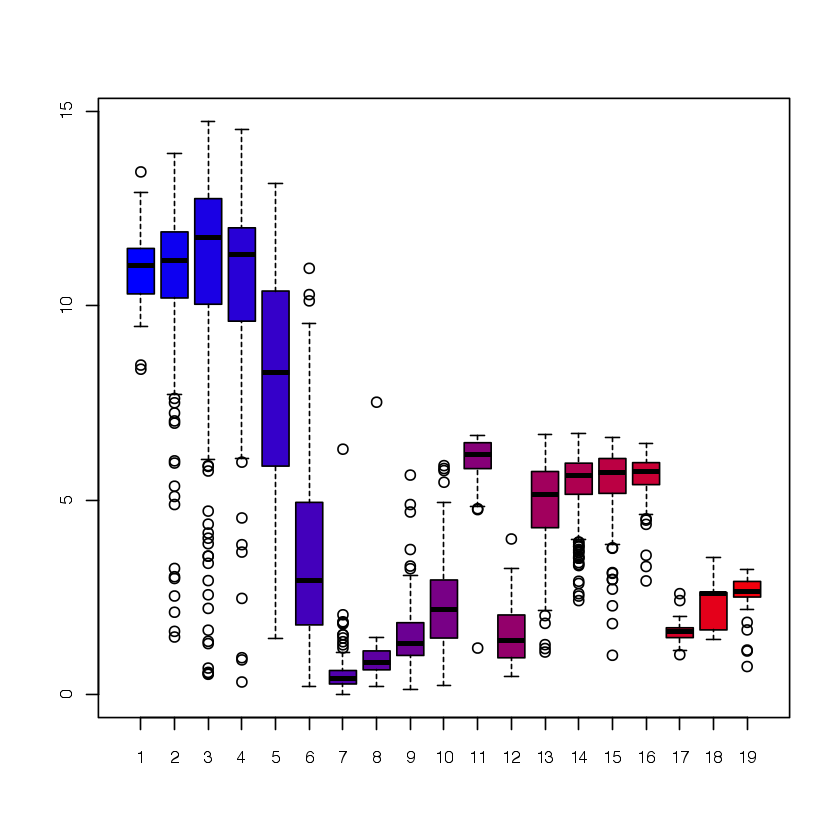

In [52]:
boxplot(dpt$DPT1 ~cluster.id, col=color.pal, cex.axis=0.8)


As a result, some clusters show high DPT values, particularly the clusters C1-C5. For the rest, there is a mixed picture. Let us check which cells are assigned to which cluster and branch, respectively.

In [53]:
confusion.matrix <- table(branching,cluster.id)


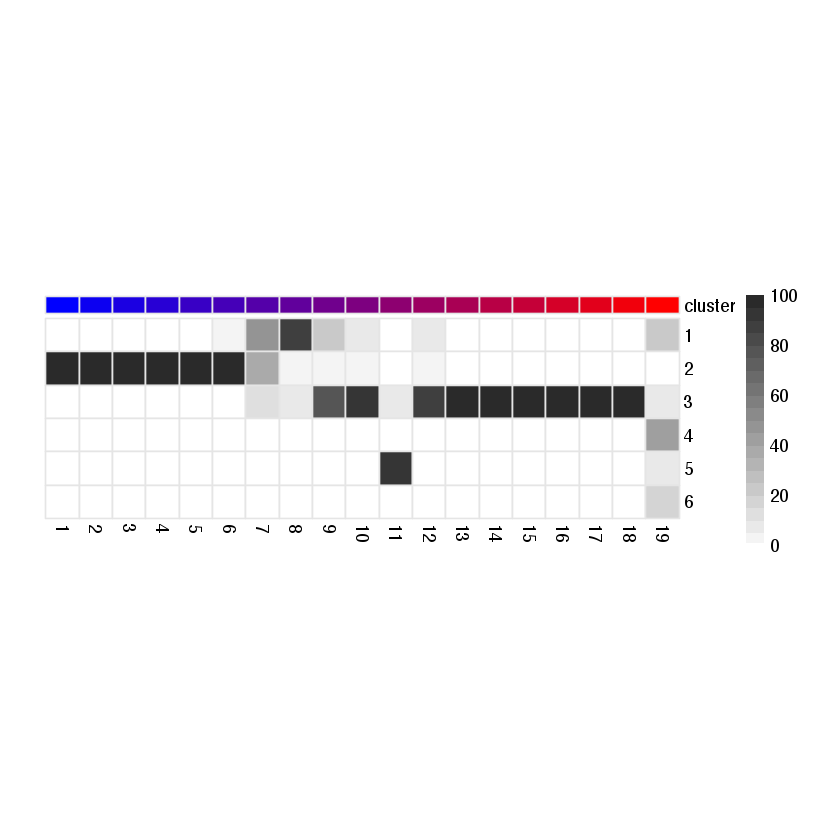

In [54]:
annotation <- data.frame(cluster = 1:19)

pheatmap(t(t(confusion.matrix) /colSums(confusion.matrix)*100), 
         border_color = 'grey90', annotation_legend = FALSE,
         breaks = c(0,1,5,seq(10,100, by=5)),
         color = colorRampPalette(c('white','black'))(25),         
         cellwidth = 20, cellheight = 20, annotation=annotation, 
         annotation_colors = list(cluster=color.pal),
         cluster_rows = FALSE, cluster_cols = FALSE)


Create the same heatmap, but with the *ComplexHeatmap* package.

In [63]:
ha_clust = HeatmapAnnotation(df = data.frame(cluster = 1:19), 
    col = list(cluster = c("1" =color.pal[1],"2" =color.pal[2], "3" =color.pal[3],
                   "4" =color.pal[4], "5" =color.pal[5], "6" =color.pal[6],
                   "7" =color.pal[7], "8" =color.pal[8], "9" =color.pal[9],
                   "10" =color.pal[10],"11" =color.pal[11],"12" =color.pal[12],
                   "13" =color.pal[13],"14" =color.pal[14],"15" =color.pal[15],
                   "16" =color.pal[16],"17" =color.pal[17],"18" =color.pal[18],
                   "19" =color.pal[19])), 
    width = unit(0.5, "cm"), which="row", show_legend = FALSE)


In [71]:
res <-t(matrix(as.numeric(confusion.matrix), ncol=length(unique(cluster.id)))) /colSums(confusion.matrix)*100


In [73]:
dim(res)

[1] 19  6

In [74]:
rownames(res) <- 1:length(unique(cluster.id))
colnames(res) <- 1:ncol(res)


In [75]:
ha_column = HeatmapAnnotation(cn = function(index) {
    branch = 1:ncol(res)
    grid.text(branch, (branch-0.5)/length(branch), 1, just = c("center", "top"))
})


In [76]:
ht_cm <- Heatmap(res,       
               show_column_names=FALSE, show_row_names =TRUE,  
               column_title= 'Branch', row_title = 'Cluster',
               column_title_side ='bottom', row_title_side='right',
               heatmap_legend_param = list(color_bar = "continuous"),
               cluster_columns = FALSE, cluster_rows =FALSE,
              name = 'Percentage',#show_heatmap_legend = FALSE,
              row_names_gp=gpar(las=2),
         col = colorRampPalette(c('white','black'))(50),
                 bottom_annotation = ha_column
               )

Warning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutztWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutzt

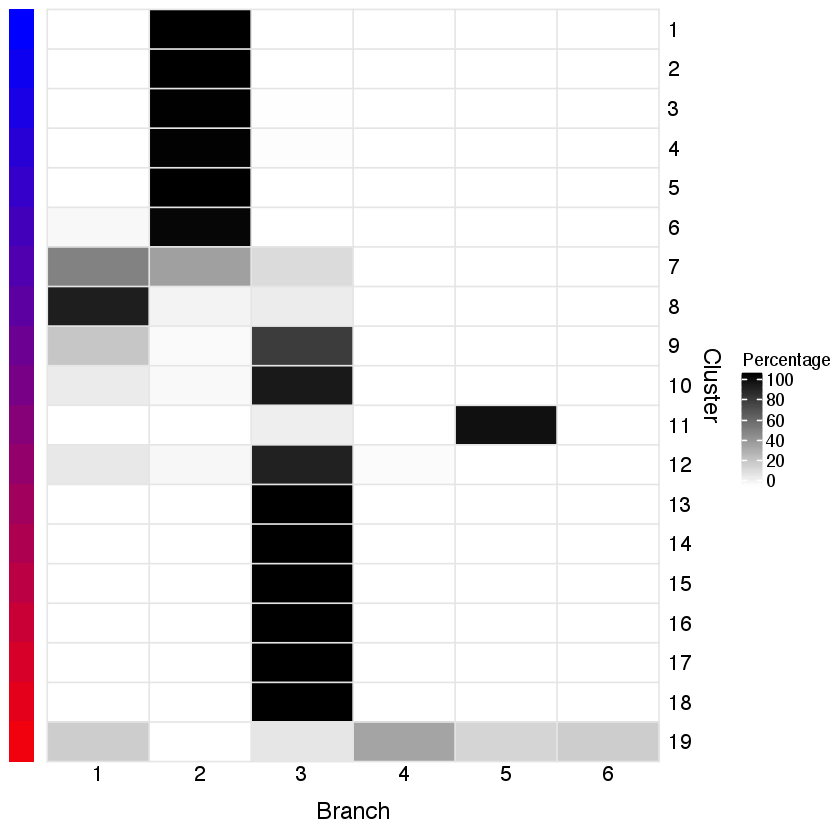

In [79]:

ha_clust+ht_cm 
ht_global_opt("heatmap_row_names_gp" = gpar(fontsize = 20), "heatmap_column_names_gp" = gpar(fontsize = 20))

decorate_heatmap_body("Percentage", {
    i = 1:ncol(res)
    x = i/ncol(res)
    for (k in i){
        grid.lines(c(x[k], x[k]), c(0, 1), gp = gpar(lwd = 1, col='grey90'))
    }
    grid.lines(c(0, 0), c(0, 1), gp = gpar(lwd = 1, col='grey90'))
    grid.lines(c(0, 1), c(0, 0),  gp = gpar(lwd = 1, col='grey90'))
    i = 1:nrow(res)
    x = i/nrow(res)
    for (k in i){
        grid.lines(c(0, 1),c(x[k], x[k]),  gp = gpar(lwd = 1, col='grey90'))
    }

})


Create density plots for the distribution of cells according to DPT for each cluster.

In [80]:
ery.cluster <- cluster.id[branching==2][order(cluster.id[branching==2])]
ery.cluster <- ery.cluster[ery.cluster !=9] #exclude the only cell originating from cluster 9 
gmp.cluster <- cluster.id[branching==3][order(cluster.id[branching==3])]
gmp.cluster <- gmp.cluster[3:length(gmp.cluster)] #exclude two single cells of cluster 3 and 4


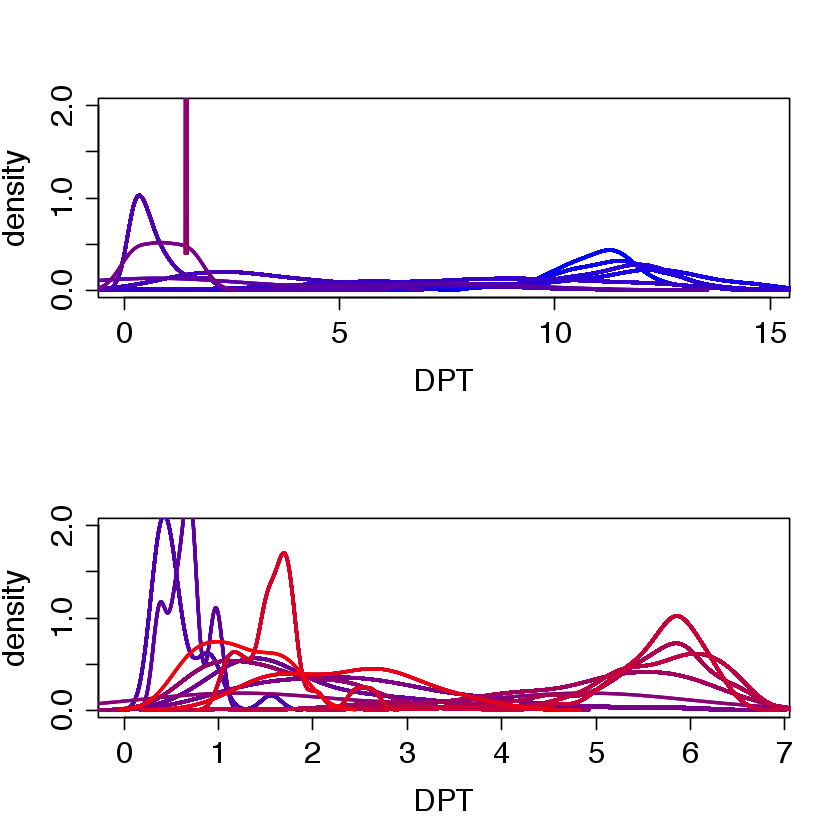

In [81]:
par(mfrow=c(2,1))

plot(NA, NA, xlim=c(min(dpt$DPT1),max(dpt$DPT1[branching==2])), ylim=c(0,2),
     cex.lab=1.5, cex.axis=1.5,
     xlab='DPT', ylab='density')
for (i in ery.cluster){
    dens.1 <- density(dpt$DPT1[branching==2 & cluster.id==i], adjust = TRUE)
    lines(dens.1, col=color.pal[i], lwd=2)
}

plot(NA, NA, xlim=c(min(dpt$DPT1),max(dpt$DPT1[branching==3])), ylim=c(0,2),
     cex.lab=1.5, cex.axis=1.5,
     xlab='DPT', ylab='density')
for (i in gmp.cluster){
    dens.1 <- density(dpt$DPT1[branching==3 & cluster.id==i], adjust = TRUE)
    lines(dens.1, col=color.pal[i], lwd=2)
}


## Revisit PCA and t-SNE

Now that we have extensively studied the branching behaviour with diffusion pseudotime, we aim to project our results onto the PCA and t-SNE plot.

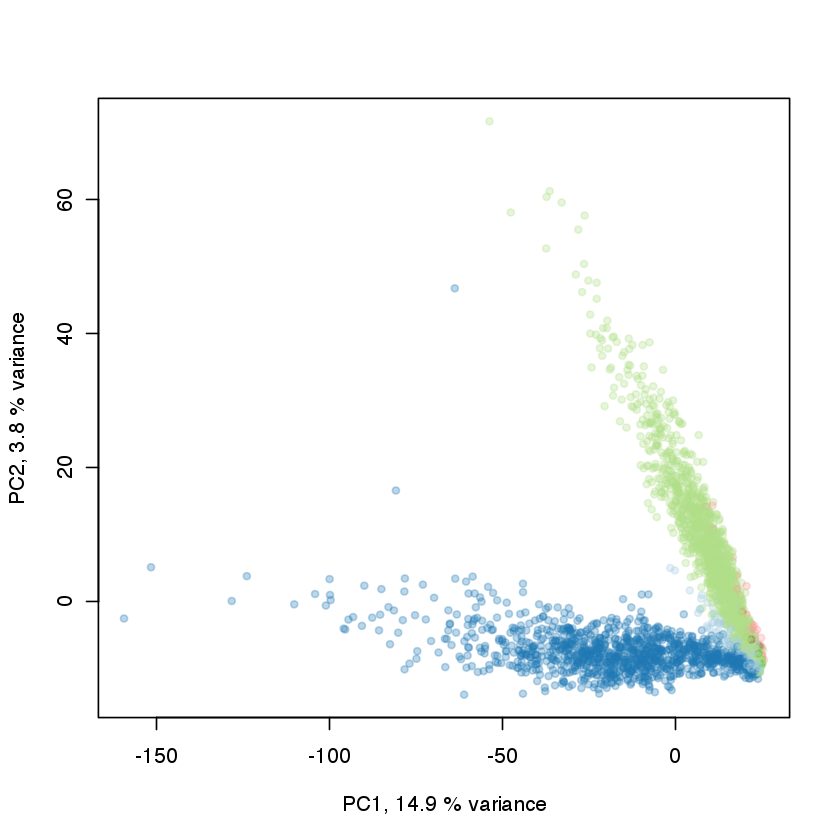

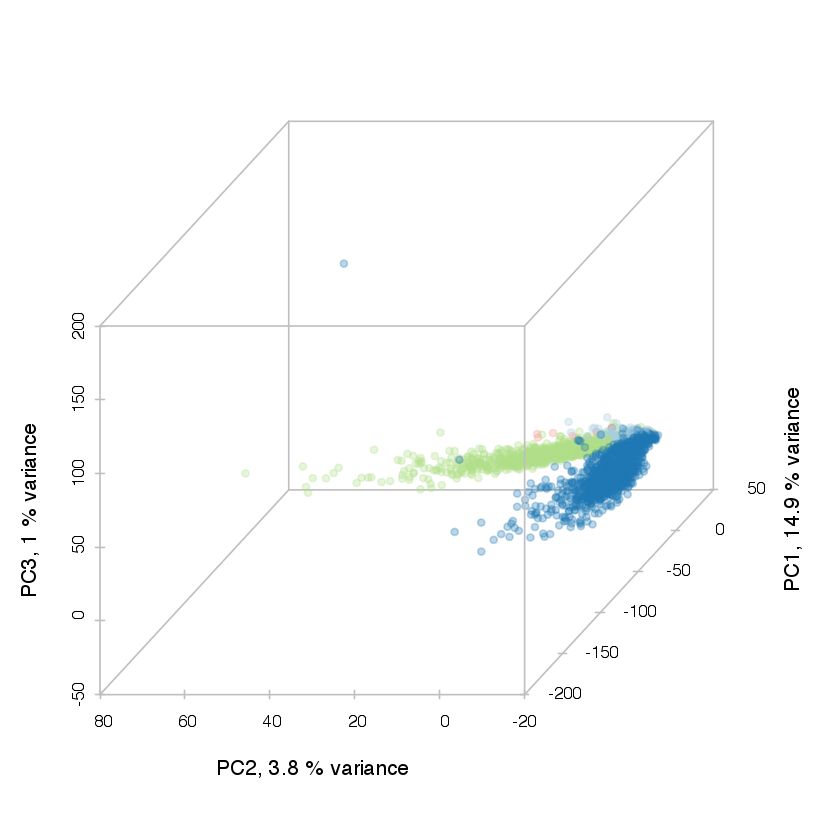

In [82]:
plot(pca.data$x[ord,1], pca.data$x[ord,2], 
     col=color.branch[branching[ord]], 
     xlab = paste0("PC1, ", var[1], " % variance"),
     ylab = paste0("PC2, ", var[2], " % variance"),
     pch= 20)
scatterplot3d(pca.data$x[ord,1], pca.data$x[ord,2], -pca.data$x[ord,3], 
              color=color.branch[branching[ord]], angle=230,
              col.axis='grey75', col.grid='white', 
     xlab = paste0("PC1, ", var[1], " % variance"),
     ylab = paste0("PC2, ", var[2], " % variance"),
     zlab = paste0("PC3, ", var[3], " % variance"),
     pch= 20)


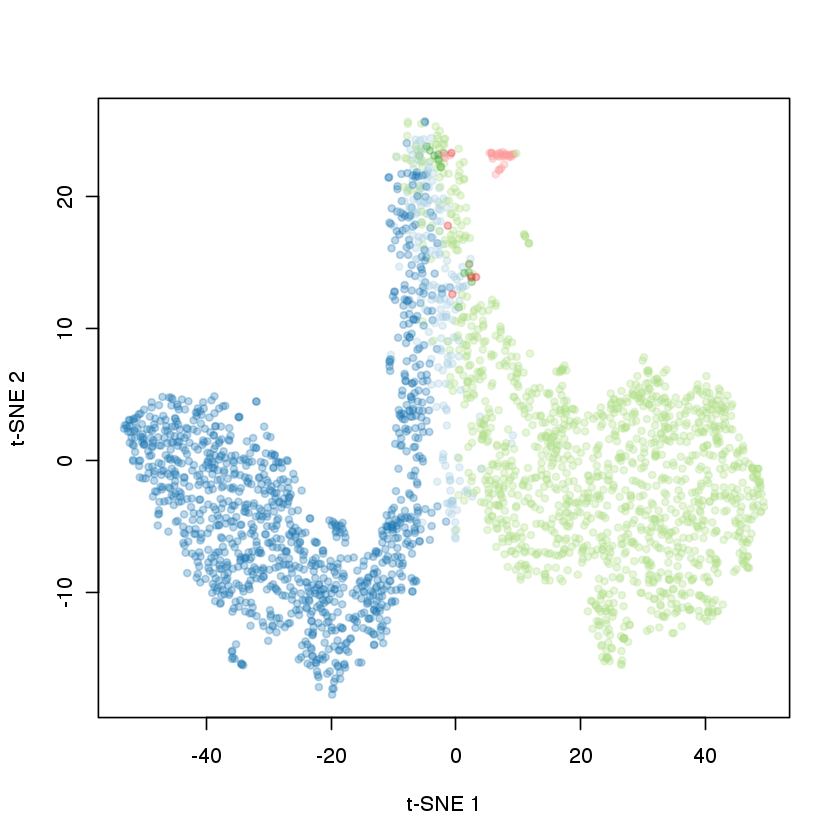

In [83]:
plot(tsne.done$Y, col=color.branch[branching], pch=20,
    xlab='t-SNE 1', ylab='t-SNE 2')


# Identification of differentiation programmes

Let us define a list of our favourite genes:

In [84]:
favour.genes <- c('Gata1', 'Phf10', 'Zfpm1', 'Gfi1b', 'Cited4', 'Klf1', 'Mbd2', 'E2f4', 'Tcf3', 'Phb2', 'Hmgb3',
                  'Cited2',  'Pbx1', 'Mef2c', 'Coro1a', 'Lyz1', 'Ccnb2', 'H2-DMa', 'Itga2b', 'Gata2', 'Sfpi1',
                  'Lmo4', 'Runx1', 'Cebpe', 'Gfi1', 'Irf8', 'Sfpi1', 'Fcgr3',  'Stat3', 'Etv6',
                  'Cebpa', 'Hbb-b1', 'Hba-a2', 'Car1', 'Car2', 'Apoe', 'Prss34', 'Mpo', 'Pf4',
                  'Serpina3f', 'Cpox', 'Cd34')


Then, we reasssure that all of our favourite genes are in the data set. 

In [85]:
which(!favour.genes %in% rownames(data.info.genes))
favour.genes[!favour.genes %in% rownames(data.info.genes)]


integer(0)

character(0)

## Pseudotemporal order for selected genes

In the following steps, we would like to gain a quick overview how particular genes develop along branch 3.

In [86]:
order.cells <- order(dpt$DPT1)


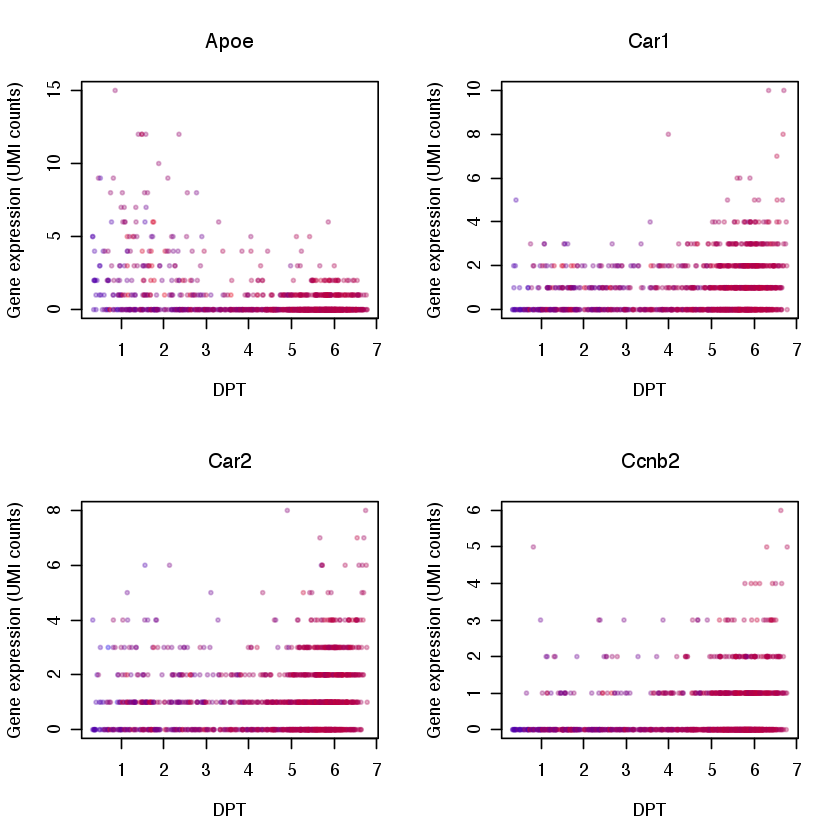

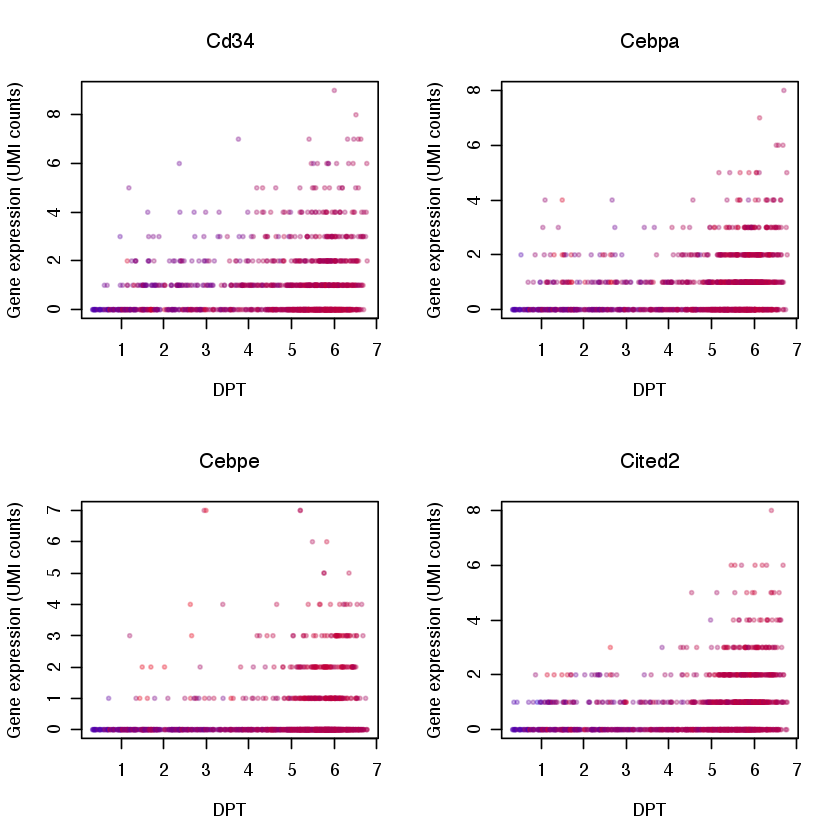

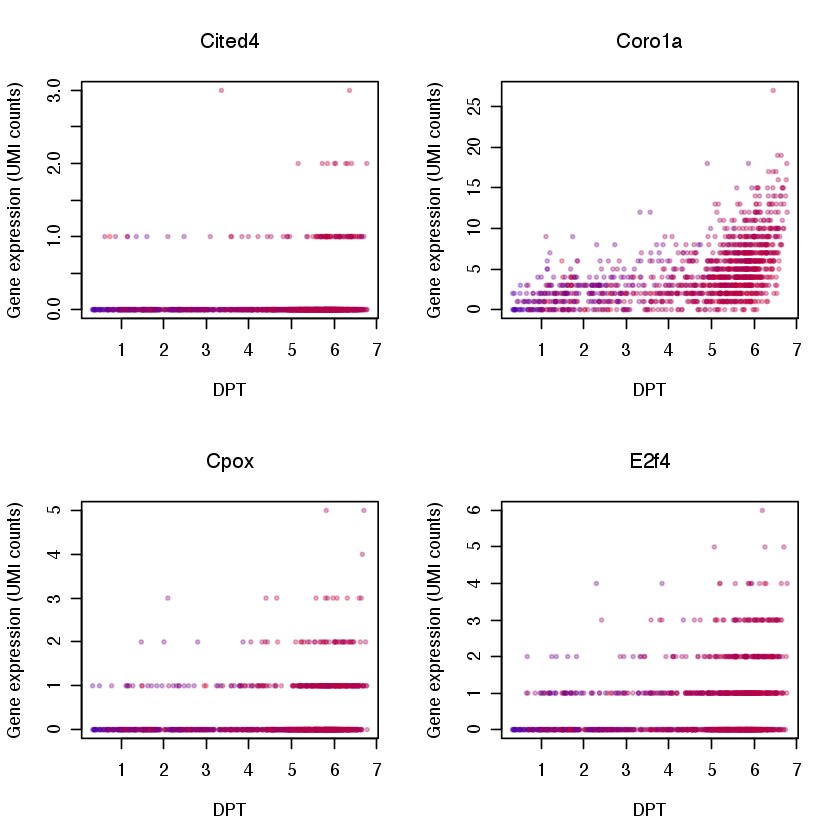

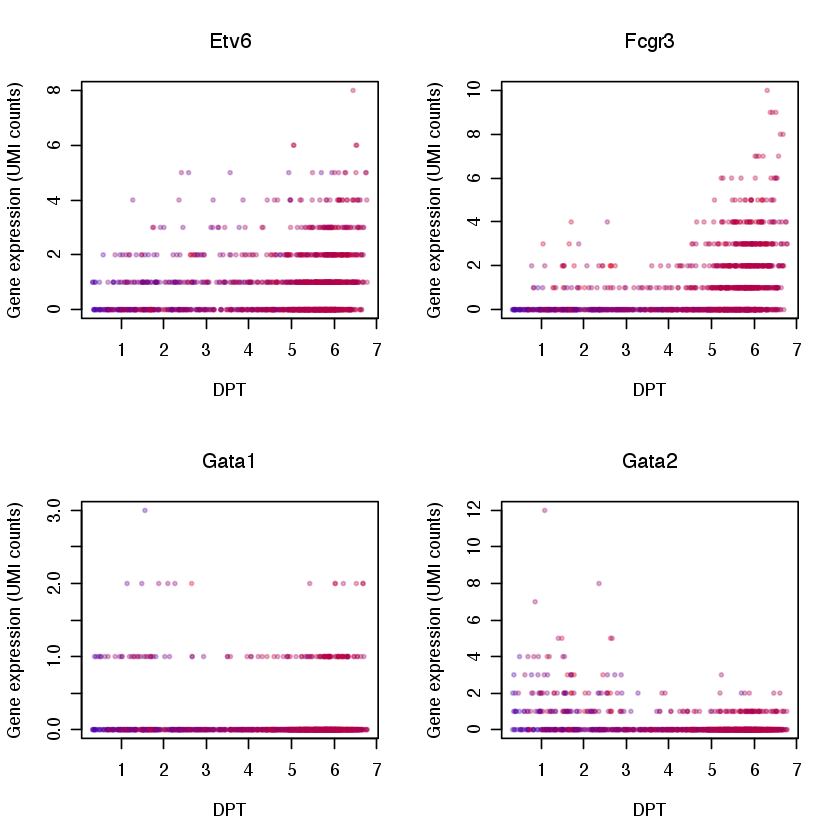

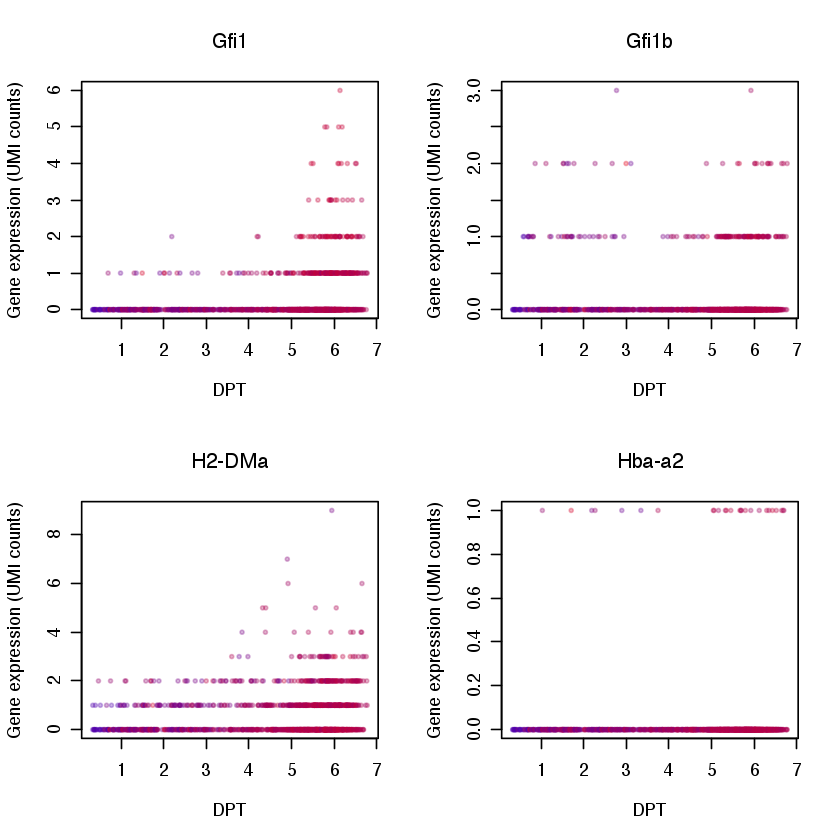

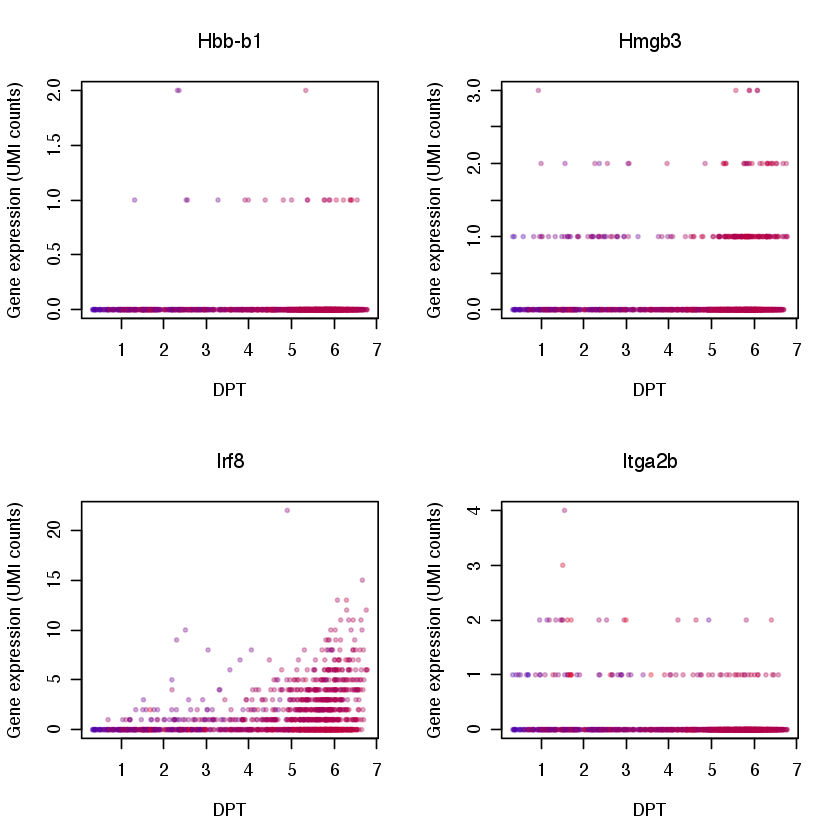

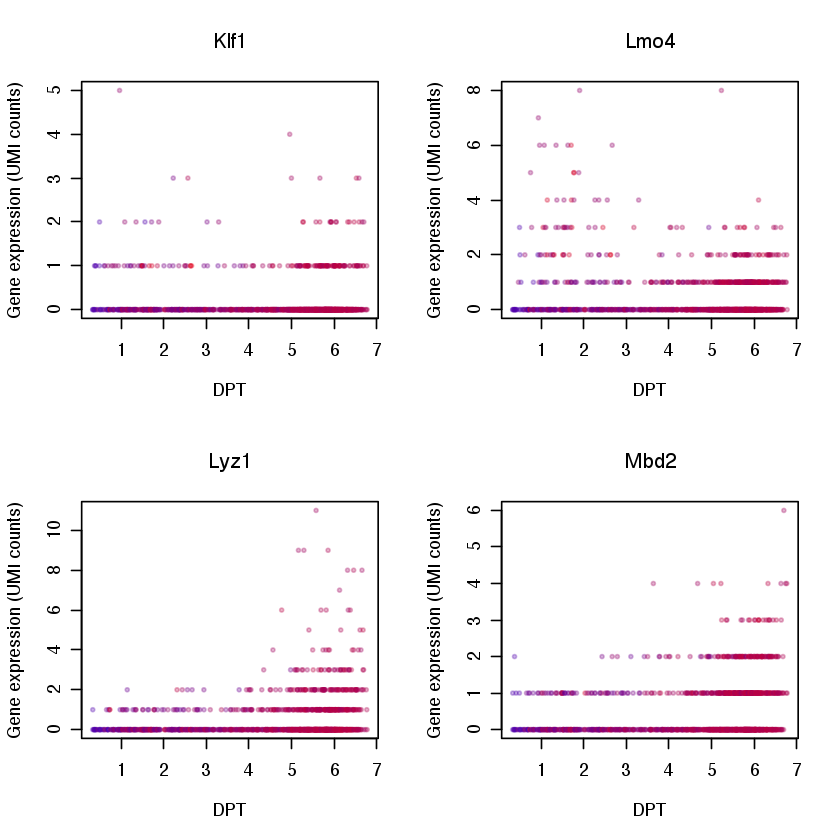

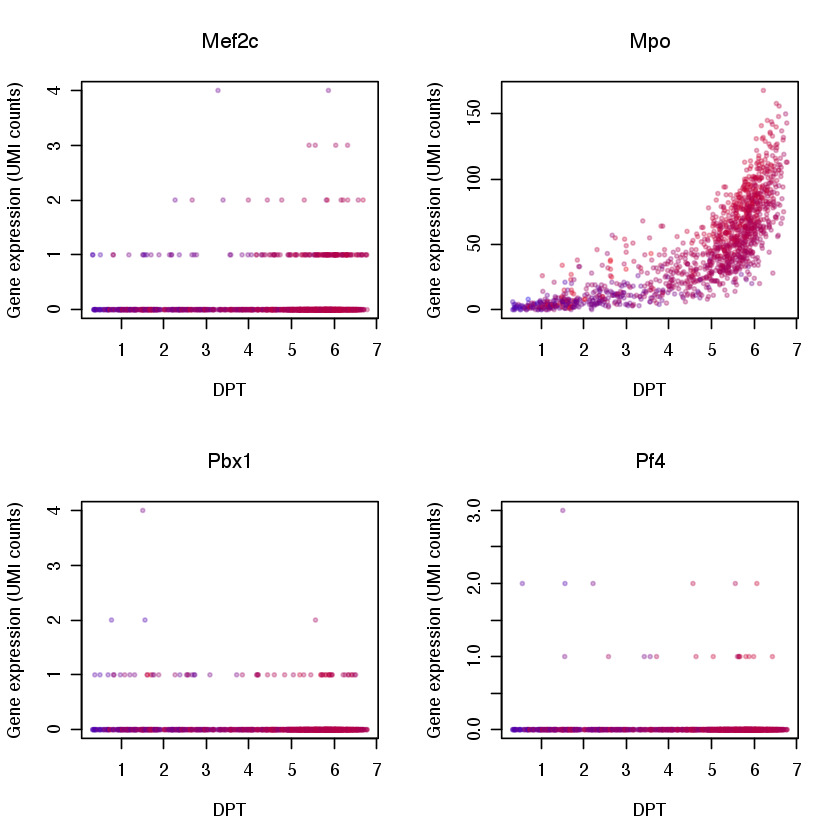

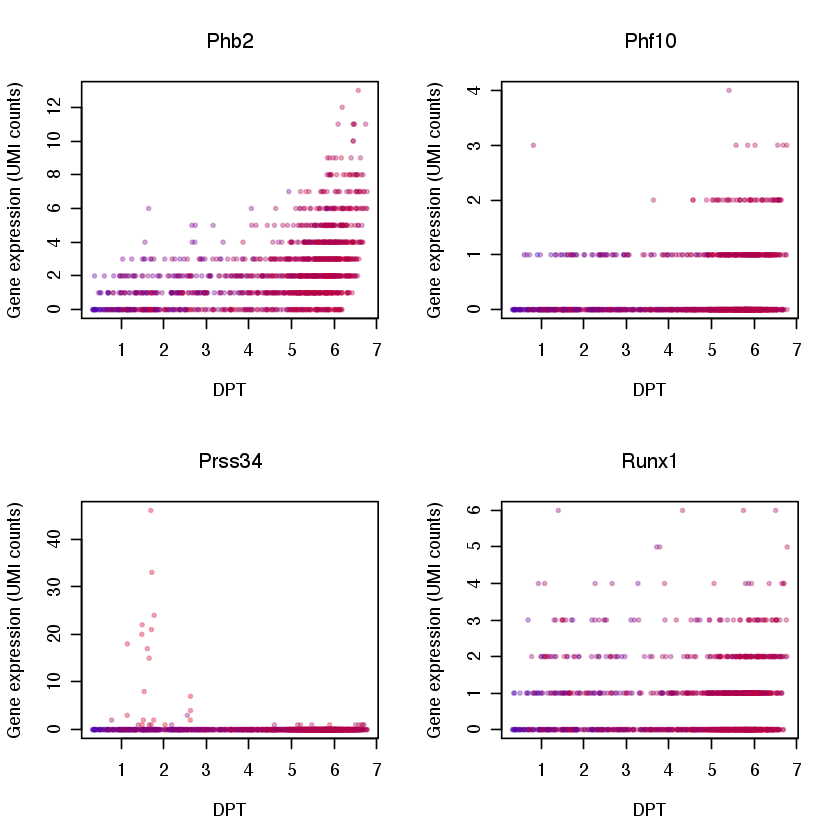

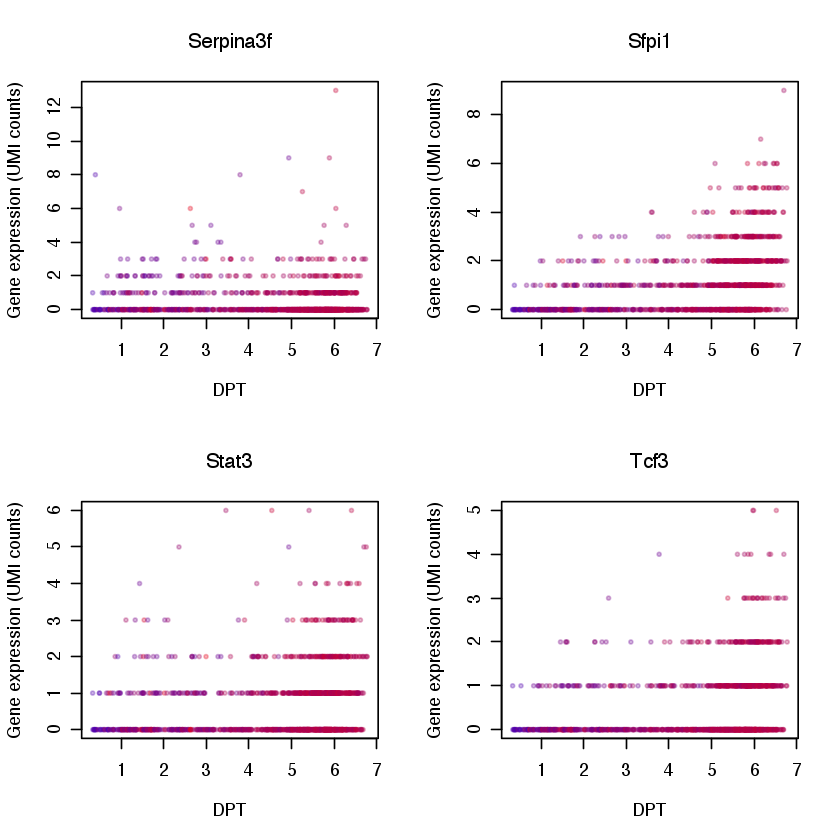

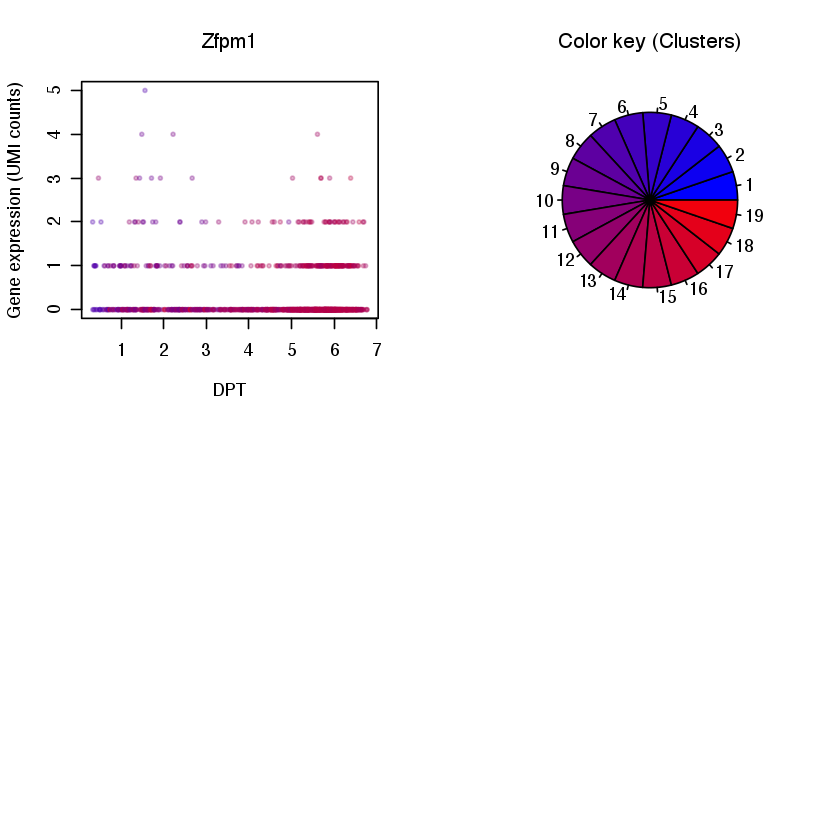

In [90]:
par(mfrow=c(2,2))
for (i in which(rownames(data.info.genes)%in%favour.genes))
    {
    const=i
plot(dpt$DPT1[order.cells[branching[order.cells]==3]],
    data.info.genes[const,order.cells[branching[order.cells]==3]], 
      main=rownames(data.info.genes)[const], cex=0.6,
     col=addalpha(color.pal,0.3)
     [cluster.id[order.cells[branching[order.cells]==3]]],
     pch=20, ylab='Gene expression (UMI counts)', xlab='DPT')
}



pie(rep(1,length(unique(cluster.id))), col=color.pal, 
    labels = 1:length(unique(cluster.id)), main='Color key (Clusters)')


Looking at the expression levels on branch 2 ordered by DPT, we find a number of genes rising (*Mpo, Sfpi1 (PU.1), Phb2* amongst others) and hardly any expression for erythroid marker genes like *Hba-a2*, *Hbb-b1* or *Gata1*.


## Heatmap for all genes

Instead of plotting each pseudotime course separately, we create a heatmap for this branch. For a particularly pretty and informative heatmap, we allow for some adjustment of the data. To group the genes by (cosine) similarity, we compute the correlation of the genes and apply hierarchical clustering with "Ward.2 method" of R. 

Make sure that there is some expression for all genes.

In [68]:
var.log.data <-apply(X = data.info.genes, MARGIN = 1, FUN = var)


In [69]:
cor.data <- cor(t(data.info.genes[var.log.data!=0,]))


Check dimensions of the correlation matrix - it should be Gene x Gene.

In [70]:
dim(cor.data)


[1] 3451 3451

Create a hierarchical clustering and create groups.

In [71]:
dd.data <- hclust(as.dist(1-cor.data), method="ward.D2")


In [72]:
cluster.hierarch <- cutree(dd.data, k=4)


Get smoothed data for all plots. Normalise by total UMI count per cell. Then normalise by 98-percentile per gene.

In [73]:
data.smooth <- data.info.genes


Get smoothed data for all plots. Normalise by 98-percentile per gene or the maximum (if 98-percentile is 0), respectively. This normalisation aims to regularise all gene expression values to the same scale. 

In [74]:
perc.98 <- apply(data.smooth[,branching %in% 1:3], MARGIN=1, quantile, c(0.98,1))
perc.98[1,min(perc.98)==0] <- perc.98[2, min(perc.98)==0] 


In [75]:
data.smooth <- data.smooth/perc.98[1,]


As an act to recover the overall trend in the data, we apply a moving average technique separately for the major branches. Branches 4 to 6 are to small to get smoothed. In addition, we average over the log-expression of the genes.

In [78]:
data.smooth.branch1 <- na.omit(apply(log(data.smooth[,order.cells[branching[order.cells]==1]]+0.01),1 , SMA, 20))
data.smooth.branch2 <- na.omit(apply(log(data.smooth[,order.cells[branching[order.cells]==2]]+0.01),1 , SMA, 20))
data.smooth.branch3 <- na.omit(apply(log(data.smooth[,order.cells[branching[order.cells]==3]]+0.01),1 , SMA, 20))


Plot heatmap.

In [79]:
ha.1 = HeatmapAnnotation(
    df = data.frame(cluster=cluster.id[order.cells[branching[order.cells]==1][20:sum(branching==1)]]), 
    col=list(cluster=c("1" =color.pal[1],"2" =color.pal[2], "3" =color.pal[3],
                   "4" =color.pal[4], "5" =color.pal[5], "6" =color.pal[6],
                   "7" =color.pal[7], "8" =color.pal[8], "9" =color.pal[9],
                   "10" =color.pal[10],"11" =color.pal[11],"12" =color.pal[12],
                   "13" =color.pal[13],"14" =color.pal[14],"15" =color.pal[15],
                   "16" =color.pal[16],"17" =color.pal[17],"18" =color.pal[18],
                   "19" =color.pal[19]
                   )), 
    show_legend = FALSE, 
    gap = unit(4, "mm"))
ha.2 = HeatmapAnnotation(
    df = data.frame(type=cluster.id[order.cells[branching[order.cells]==2]][20:sum(branching==2)]), 
    col=list(type=c("1" =color.pal[1],"2" =color.pal[2], "3" =color.pal[3],
                   "4" =color.pal[4], "5" =color.pal[5], "6" =color.pal[6],
                   "7" =color.pal[7], "8" =color.pal[8], "9" =color.pal[9],
                   "10" =color.pal[10],"11" =color.pal[11],"12" =color.pal[12],
                   "13" =color.pal[13],"14" =color.pal[14],"15" =color.pal[15],
                   "16" =color.pal[16],"17" =color.pal[17],"18" =color.pal[18],
                   "19" =color.pal[19]
                   )), 
    show_legend = FALSE,
    gap = unit(4, "mm"))
ha.3 = HeatmapAnnotation(
    df = data.frame(type=cluster.id[order.cells[branching[order.cells]==3]][20:sum(branching==3)]),
    col=list(type=c("1" =color.pal[1],"2" =color.pal[2], "3" =color.pal[3],
                   "4" =color.pal[4], "5" =color.pal[5], "6" =color.pal[6],
                   "7" =color.pal[7], "8" =color.pal[8], "9" =color.pal[9],
                   "10" =color.pal[10],"11" =color.pal[11],"12" =color.pal[12],
                   "13" =color.pal[13],"14" =color.pal[14],"15" =color.pal[15],
                   "16" =color.pal[16],"17" =color.pal[17],"18" =color.pal[18],
                   "19" =color.pal[19]
                   )), 
    show_legend = FALSE, 
    gap = unit(4, "mm"))

In [80]:
cluster.color <- brewer.pal(8, 'Set1')


In [81]:
ha.row = HeatmapAnnotation(df = data.frame(cluster = cluster.hierarch), 
    col = list(cluster = c("1" = cluster.color[1], 
                           "2" = cluster.color[2], 
                           "3" = cluster.color[3],
                           "4" = cluster.color[4])),
    width = unit(0.5, "cm"), which="row", show_legend = FALSE)

In [82]:
ht1 <- Heatmap( t(data.smooth.branch1), 
                  row_dend_width = unit(3, "cm"),              
               show_row_names = FALSE, 
               show_heatmap_legend = FALSE,
               column_title = 'trunk',
               heatmap_legend_param = list(color_bar = "continuous"),
               cluster_columns = FALSE, 
               cluster_rows =as.dendrogram(dd.data),
              name = 'expression',
               col=colorRamp2(seq(-4.6,-0.2, length.out = 13), c('grey75', rev(brewer.pal(11, "RdYlBu")), 'black')),
                top_annotation=ha.1
               )
ht2 <- Heatmap( t(data.smooth.branch2), 
                  row_dend_width = unit(3, "cm"),              
               show_row_names = FALSE, 
               show_heatmap_legend = FALSE,column_title = 'branch 2',
               heatmap_legend_param = list(color_bar = "continuous"),
               cluster_columns = FALSE, cluster_rows =as.dendrogram(dd.data),
              name = 'expression',
               col=colorRamp2(seq(-4.6,-0.2, length.out = 13), c('grey75', rev(brewer.pal(11, "RdYlBu")), 'black')),
                top_annotation=ha.2
               )
ht3 <- Heatmap( t(data.smooth.branch3), 
                  row_dend_width = unit(3, "cm"),              
               show_row_names = FALSE, 
               show_heatmap_legend = TRUE,
               column_title = 'branch 3',
               heatmap_legend_param = list(color_bar = "continuous"),
               cluster_columns = FALSE, cluster_rows =as.dendrogram(dd.data),
              name = 'expression',
               col=colorRamp2(seq(-4.6,-0.2, length.out = 13), c('grey75', rev(brewer.pal(11, "RdYlBu")), 'black')),
                top_annotation=ha.3
               )

Warning message:
In .local(object, ...): Heatmap/row annotaiton names are duplicated: expressionWarning message:
In .local(object, ...): Heatmap/row annotaiton names are duplicated: expression, expressionWarning message:
In .local(object, ...): Heatmap/row annotaiton names are duplicated: expression, expressionWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutztWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutztWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutztWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutzt

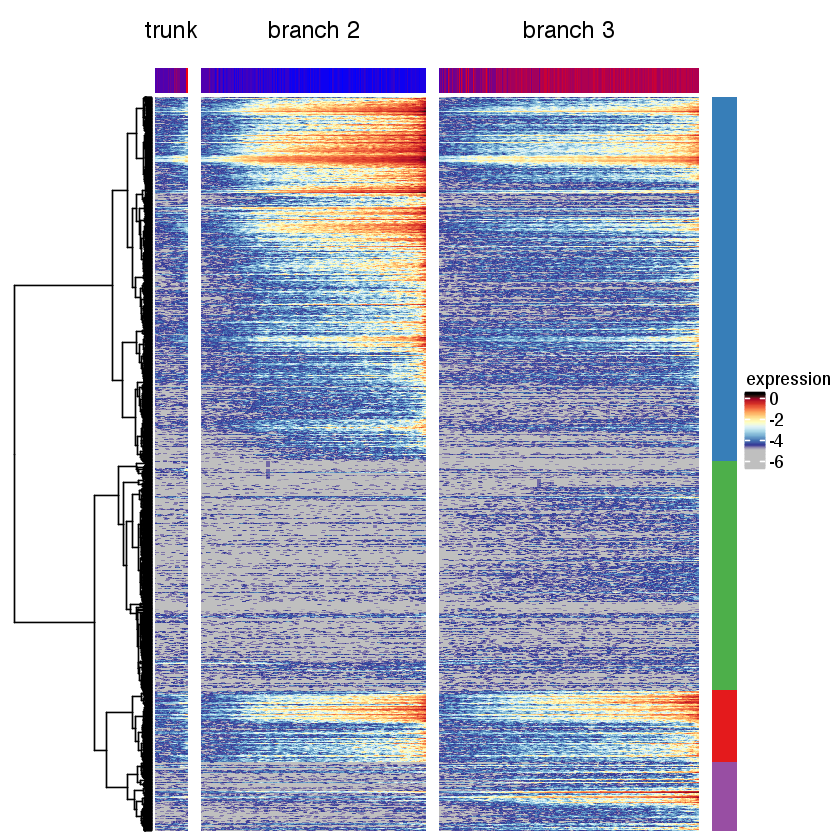

In [83]:
ht1 +ht2 + ht3 + ha.row

Now let us reduce the large heatmap plot to our favourite gene set.

In [84]:
cor.data.fav <- cor(t(data.info.genes[var.log.data!=0 & rownames(data.info.genes) %in% favour.genes,]))

In [85]:
dd.data.fav <- hclust(as.dist(1-cor.data.fav), method="ward.D2")

Create the heatmap.

In [86]:
ht1.fav <- Heatmap( t(data.smooth.branch1[,rownames(data.info.genes) %in% favour.genes]), 
                  row_dend_width = unit(3, "cm"),              
               show_row_names = FALSE, #width=unit(3, "cm"),
               show_heatmap_legend = FALSE, column_title = 'trunk',
               heatmap_legend_param = list(color_bar = "continuous"),
               cluster_columns = FALSE, cluster_rows =as.dendrogram(dd.data.fav),
              name = 'expression',#show_heatmap_legend = FALSE,
               col=colorRamp2(seq(-4.6,-0.2, length.out = 13), c('grey75', rev(brewer.pal(11, "RdYlBu")), 'black')),
                top_annotation=ha.1#, top_annotation_height = unit(2, "cm")
               )
ht2.fav <- Heatmap( t(data.smooth.branch2[,rownames(data.info.genes) %in% favour.genes]),  
                  row_dend_width = unit(3, "cm"),              
               show_row_names = FALSE, #width=unit(3, "cm"),
               show_heatmap_legend = FALSE,column_title = 'branch 2',
               heatmap_legend_param = list(color_bar = "continuous"),
               cluster_columns = FALSE, cluster_rows =as.dendrogram(dd.data.fav),
              name = 'log(expression)',#show_heatmap_legend = FALSE,
               col=colorRamp2(seq(-4.6,-0.2, length.out = 13), c('grey75', rev(brewer.pal(11, "RdYlBu")), 'black')),
                top_annotation=ha.2#, top_annotation_height = unit(2, "cm")
               )
ht3.fav <- Heatmap( t(data.smooth.branch3[,rownames(data.info.genes) %in% favour.genes]),  
                  row_dend_width = unit(3, "cm"),              
               show_row_names = TRUE, #width=unit(3, "cm"),
                   row_names_gp = gpar(fontsize = 10),
               show_heatmap_legend = TRUE,
                   column_title = 'branch 3',
               heatmap_legend_param = list(color_bar = "continuous"),
               cluster_columns = FALSE, cluster_rows =as.dendrogram(dd.data.fav),
              name = 'expression',#show_heatmap_legend = FALSE,
               col=colorRamp2(seq(-4.6,-0.2, length.out = 13), c('grey75', rev(brewer.pal(11, "RdYlBu")), 'black')),
                top_annotation=ha.3#, top_annotation_height = unit(2, "cm")
               )

In [87]:
ha.row.fav = HeatmapAnnotation(df = data.frame(cluster = cluster.hierarch
                                                 [rownames(data.info.genes) %in% favour.genes]), 
    col = list(cluster = c("1" =  cluster.color[1], 
                           "2" = cluster.color[2], 
                           "3"=cluster.color[3],
                           "4"=cluster.color[4])), 
    width = unit(0.5, "cm"), which="row", show_legend = FALSE)

Warning message:
In .local(object, ...): Heatmap/row annotaiton names are duplicated: expressionWarning message:
In .local(object, ...): Heatmap/row annotaiton names are duplicated: expressionWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutztWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutztWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutztWarning message:
In if (class(oe) == "try-error") {: Bedingung hat Länge > 1 und nur das erste Element wird benutzt

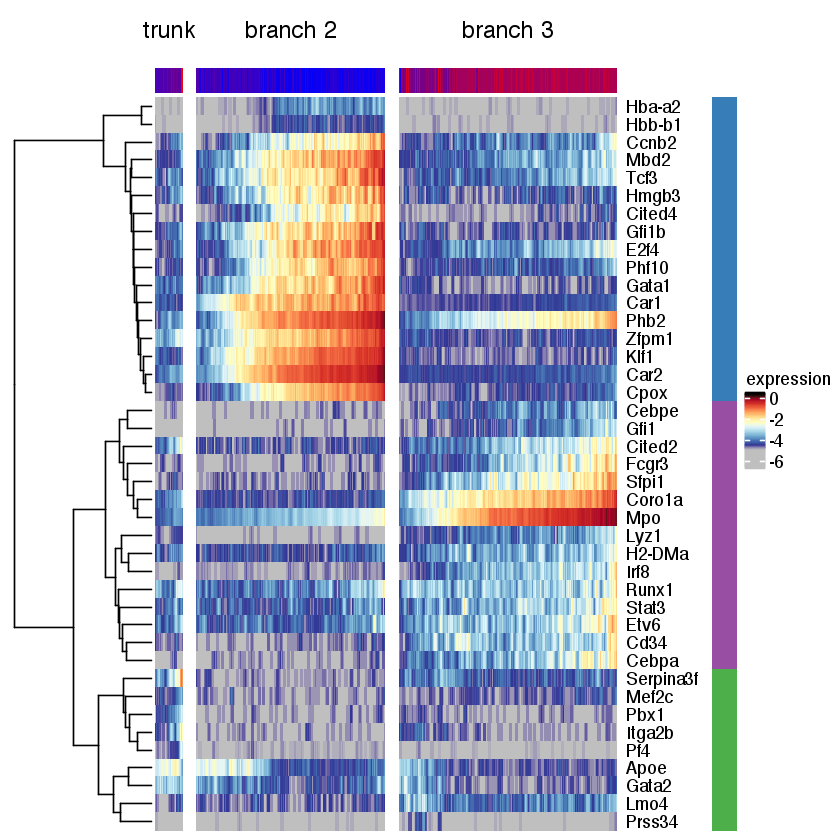

In [88]:
ht1.fav + ht2.fav + ht3.fav + ha.row.fav

# Downstream analyses

The tutorial on single-cell analysis stops here but provides some suggestions for further analysis. Up to this point, we have assessed the quality and properties of the data, filtered them to an *informative* subset and inspected different methods to visualise and inspect the data in low dimensions. For this data set, pseudotemporal ordering was a suitable approach to identify different lineages as we did not observe a cluster structure in the data. A heatmap with hierarchical clustering of similar gene sets allows us to identify the cell type that develops in each branch. 

Still, we should employ **gene set enrichment analysis** to investigate the significance and plausibility of our results. The following tools provide this function (amongst others):

* RAMONA http://mips.helmholtz-muenchen.de/mona/
* GeneRanker from Genomatix http://www.genomatix.de
* topGO R package 


Further, **differential expression analysis** is used to identify significantly different genes. A standard workflow is to define two or more sets of cells that you consider meaningful (in our example, we could choose 200 cells from the tips of branch 2 and 3) and perform a differential expression test in R with:

* DESeq2 (uses a negative binomial model)
* edgeR (similar to DESeq2)
* SCDE (Bayesian model, considers drop-out events)
* MAST (Mixture model of drop-out rate and mean expression)
* BASiCS (Bayesian framework)
* RaceID (Clustering and differential gene expression analysis based on binomial test)
* SC3 (Single-cell Consensus Clustering)
* M3Drop (Michaelis-Menten Modelling of Dropouts in single-cell RNASeq)

However, the development of analysis tools is a productive field of research and there is no such thing as a *Gold standard* here. 


# Some further reading

A workflow of single-cell RNAseq analysis stressing different aspects is available at https://www.bioconductor.org/help/workflows/simpleSingleCell/

*scater*: Single-cell analysis toolkit for gene expression data in R.

*scran*: Methods for Single-Cell RNA-Seq Data Analysis.

# Session information

In [89]:
sessionInfo()

R version 3.3.0 (2016-05-03)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.11.6 (El Capitan)

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] TTR_0.23-1                  pheatmap_1.0.8             
 [3] MASS_7.3-45                 destiny_2.1.0              
 [5] Rtsne_0.11                  MAST_0.934                 
 [7] reshape_0.8.5               circlize_0.3.9             
 [9] ComplexHeatmap_1.11.7       scatterplot3d_0.3-37       
[11] RColorBrewer_1.1-2          colorRamps_2.3             
[13] DESeq2_1.13.14              SummarizedExperiment_1.3.82
[15] Biobase_2.33.3              GenomicRanges_1.25.94      
[17] GenomeInfoDb_1.9.13         IRanges_2.7.15             
[19] S4Vectors_0.11.17           BiocGenerics_0.19.2        
[21] gplots_3.0.1                ggplot

# References

[1] Paul et al: Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors, **Cell 163**, 1663–1677, 2015

[2] Haghverdi et al: Diffusion Pseudotime Robustly Reconstructs Lineage Branching, **Nature Methods 13(10)**, 845-848, 2016 

[3] van der Maaten, and Hinton: Visualizing High-Dimensional Data Using t-SNE, **Journal of Machine Learning Research 9**, 2579–2605, 2008

[4] Haghverdi et al: Diffusion maps for high-dimensional single-cell analysis of differentiation data, **Bioinformatics 31(18)**, 2989-2998, 2015